# **Diabetes Classification: To what extent can classification models succeed at diagnosing diabetes from tabular data?**

Annie Wernerfelt, Silvani Amin, Xiang Chen

CIS 5450 Final Project Sp 2024

## ***Part 0: Background***

Our team embarked on a journey with the objective of harnessing the power of data analysis and machine learning for a cause that extends beyond academic curiosity — to explore health and demographic data with potential benefits to to healthcare settings. Specifically, our focus was directed towards the exploration of various health factors and conditions in an attempt to unearth any underlying correlations that may exist with an increased risk of diabetes. This endeavor was not just about probing data for the sake of discovery; it was driven by a purposeful mission to shed light on critical insights that could pave the way for preventative strategies, early interventions, and possibly, more personalized approaches to diabetes care. Through this project, we aimed to bring the realms of technology and healthcare closer, providing a valuable intersection where data-driven decisions could lead to healthier lives.

In this session we hope to explore the following questions: Which features are most correlated to a patient being diagnosed with diabetes? To what extent can ML determine if a person is high-risk for diabetes? Lastly, which classifier model is most suited for robust diabetes classification from tabular data?

## ***Part 1: Setting Up Project with Data and Any Needed Libaries***

In [ ]:
#Importing libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
import pandasql as ps #SQL on Pandas Dataframe
import nltk
nltk.download('punkt')
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import math
import re
import json
import os
from collections import Counter
from PIL import Image
import random
from string import ascii_letters
import matplotlib.pyplot as plt
import requests
from lxml import html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Read in the dataset
df = pd.read_csv("C:\\Users\\xiang\\Downloads\\archive\\diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## ***Part 2: Exploratory Data Analysis***
The features in our dataset are smoking history, gender, hypertension, heart disease, BMI (body mass index), HbA1c_level (hemoglobin level), blood glucose level, and the label, diabetes. For the EDA section, our problem statement is that we want to find which features are most predictive of diabetes, and to understand which feature values are most correlated with diabetes. We describe the summary statistics and distribution of the variables in this section as well.

### *Part 2.1: Cleaning the data with ordinal encoding and standard scaling*

We will use the Kaggle Diabetes Prediction Dataset set up from Part 0. In this section, we clean the dataset by changing the values in the smoking history and gender columns. We combined the values 'ever', 'not current', and 'former' for the smoking history variable, because these essentially mean the same thing. We then applied an ordinal encoder to these features, as well as a standard scaler. We use the standard scaled data for our train test splits, but for our EDA we do not use the scaled data because we want the feature values to still have their meaning. Standard scaling the data handles outliers and makes the distribution more normal.

In [ ]:
#Ordinal Encoding of features
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
def relabel_smoking(row):
   if row['smoking_history']=='ever':
      return 'former'
   if row['smoking_history']=='not current':
      return 'former'
   else:
      return row['smoking_history']
def relabel_gender(row):
   if row['gender']=='Other':
      return 'no info'
   else:
      return row['gender']
df['smoking_history']=df.apply(relabel_smoking, axis=1)
df['gender']=df.apply(relabel_gender, axis=1)
ordered_categories = [['No Info','never', 'former','current'],['Male','Female','no info']]
ordered_features=['smoking_history', 'gender']

# Apply Ordinal Encoding to ordered columns in the dataset.
notord_df = df.drop(ordered_features, axis=1)
ord_df = df.loc[:, ordered_features]
ord_df = ord_df.dropna()

enc = OrdinalEncoder(categories=ordered_categories).fit(ord_df)

ordlabels = enc.transform(ord_df)

ordfeats = pd.DataFrame(ordlabels, columns=ordered_features)
df = ordfeats.join(notord_df, how="left")

Here we create our train-test split using our cleaned data.

In [ ]:
#Scale the numerical features
scaler = StandardScaler()
X=df.loc[:, df.columns != 'diabetes']
y=df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y, shuffle=True)
cols=['smoking_history','gender','age','heart_disease','bmi','HbA1c_level','blood_glucose_level']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

### *Part 2.2: Cleaning the second dataset with standard scaling*
This second dataset will only be used later to see how our models generalize. But, we'll set it up here and clean it through standard scaling, and make a train/test split.

### *Part 2.3: Finding summary statistics of input data*
First, we want to look at whether there is a class balance in our dataset. Is there an equal number of individuals with diabetes as there is individuals without diabetes? The answer to this question will be important when we look at training classifiers later.
Then, we show summary data for each non-binary features including descriptions of mean, standard deviation, median, minimum, and maximum.

In [ ]:
print(f"There are {df[df['diabetes'] ==0].shape[0]} non-diabetic individuals in this dataset")
print(f"There are {df[df['diabetes'] ==1].shape[0]} diabetic individuals in this dataset.")

There are 91500 non-diabetic individuals in this dataset
There are 8500 diabetic individuals in this dataset.


***Class Imbalance***
In this dataset, only 8.5% of individuals are positive for diabetes. This is a pretty big class imbalance.

Next, we look at the summary statistics of each of our features. This gives us an idea of the range and distribution of each of the features within the data. For true/false features, this just gives us the percentage of people in the dataset where the value is true (7% of people in the dataset have hypertension, for example). We can also see that there aren't null values in our dataset. The average age is 42 years and the average BMI is 27. We do see an outlier in the BMI category because the value 95.7 is very far from the 75th percentile of 29.6.

In [ ]:
df[["gender", "age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level"]].describe().round(1)

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,0.6,41.9,0.1,0.0,27.3,5.5,138.1
std,0.5,22.5,0.3,0.2,6.6,1.1,40.7
min,0.0,0.1,0.0,0.0,10.0,3.5,80.0
25%,0.0,24.0,0.0,0.0,23.6,4.8,100.0
50%,1.0,43.0,0.0,0.0,27.3,5.8,140.0
75%,1.0,60.0,0.0,0.0,29.6,6.2,159.0
max,2.0,80.0,1.0,1.0,95.7,9.0,300.0


Let's drop that BMI outlier. 3 standard deviations from the mean is 47.1. This calculation also tells us there isn't an outlier in the other direction, because the minimum, 10.0, is greater than 7.5, which is 3 standard deviations from the mean.

We also looked for outliers in HbA1c_level and blood_glucose_level, and dropped them.

In [ ]:
df = df.drop(df[df['bmi'] >= (27.3+3*6.6)].index)
df = df.drop(df[df['bmi'] <= (27.3-3*6.6)].index)
df = df.drop(df[df['HbA1c_level'] >= (5.5+3*1.1)].index)
df = df.drop(df[df['HbA1c_level'] <= (5.5-3*1.1)].index)
df = df.drop(df[df['blood_glucose_level'] >= (138.1+3*40.7)].index)
df = df.drop(df[df['blood_glucose_level'] <= (138.1-3*40.7)].index)

A big contribution of our EDA section is our correlation heatmap. The correlation heatmap gives us a lot of insight into which features are most predictive of diabetes. We see the hemoglobin level, blood glucose level, and age are the most predictive. We also see that age is highly correlted with many features, including BMI, hypertension, smoking history, and heart disease. Next, we'll quantify these relationships and seek to understand which feature values are most predictive of diabetes.

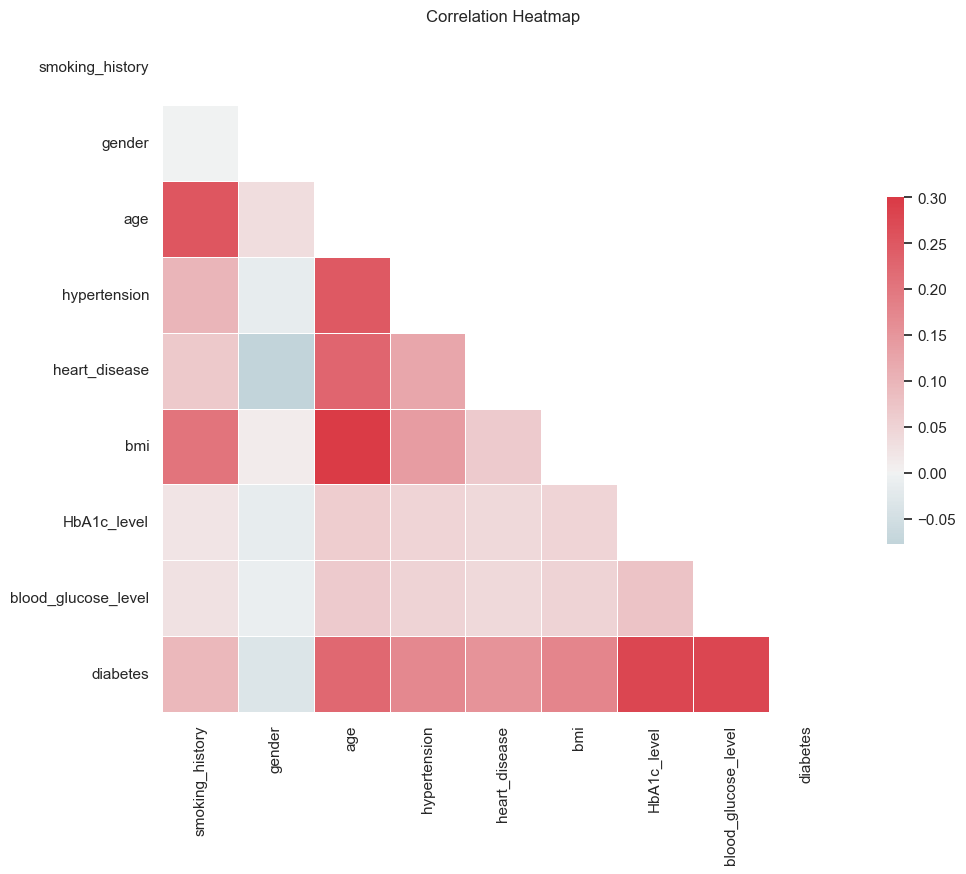

In [ ]:
#This code is taken from Homework 1

correlation_matrix=df.corr()
sns.set(style = "white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = correlation_matrix

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show()

Lets start by comparing smoking history with diabetes. Based on our data cleaning, we defined that a higher number for the smoking history feature means more current smoking was reported. From this EDA we see that smoking does have a correlation with diabetes, but former smokers have a higher incidence of diabetes than current smokers. We also can't make any conclusions about causation here.



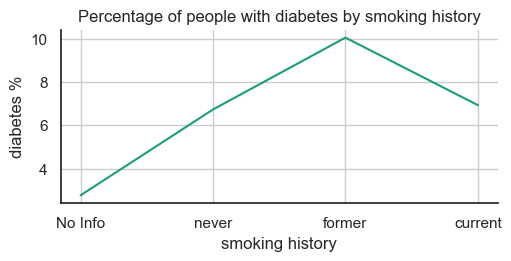

In [ ]:
#we will use pandas to filter the types of smoking history and probability of getting diabetes
smoking_df = df.groupby(by = "smoking_history")["diabetes"].mean().reset_index()
smoking_df
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = ['No Info','never', 'former','current']
  ys = 100*series['diabetes']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5, 2.5), layout='constrained')
_plot_series(smoking_df, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('smoking history')
plt.title("Percentage of people with diabetes by smoking history")
plt.grid()
_ = plt.ylabel('diabetes %')

We also wish to see if a certain gender has a higher incidence of diabetes. The below results indicate that men have a slightly higher probability of having diabetes in our dataset. Again we can't infer causality, we can just notice correlation.

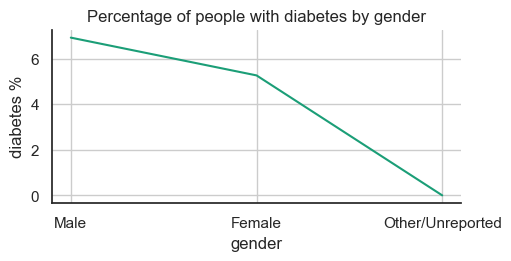

In [ ]:
#Below we look at diabetes presence comparing genders
gender_query = '''
select gender, avg(diabetes) as diabetes_percentage
from df
group by gender
'''
gender_query_sql = ps.sqldf(gender_query, locals())
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = ["Male","Female","Other/Unreported"]
  ys = 100*series['diabetes_percentage']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5, 2.5), layout='constrained')
_plot_series(gender_query_sql, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('gender')
plt.title("Percentage of people with diabetes by gender")
plt.grid()
_ = plt.ylabel('diabetes %')

Now we'll look at the relationship between BMI and diabetes. As a reminder, the plots and queries in this section are from the whole dataset, not the standard-scaled train and test splits. So, the averages we see have meaning beyond just comparison. We plotted the average BMI for each category to show that the mean BMI for people without diabetes is lower than the mean for people with diabetes.

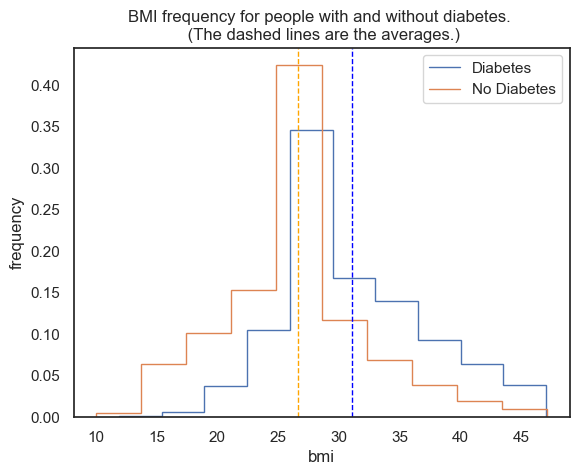

In [ ]:
pos_df=df[df['diabetes'] ==1]
neg_df=df[df['diabetes'] ==0]
counts, bins = np.histogram(pos_df['bmi'])
plt.stairs(counts / pos_df.shape[0], bins, label='Diabetes')
counts, bins = np.histogram(neg_df['bmi'])
plt.stairs(counts / neg_df.shape[0], bins, label='No Diabetes')
plt.xlabel('bmi')
plt.ylabel('frequency')
plt.title('BMI frequency for people with and without diabetes. \n (The dashed lines are the averages.)')
plt.legend()
plt.axvline(pos_df.bmi.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(neg_df.bmi.mean(), color='orange', linestyle='dashed', linewidth=1)
plt.show()

People with diabetes are about 5 times more likely to have heart disease than people without diabetes.

In [ ]:
smoker_query = '''
SELECT 100*round(avg(heart_disease),4) as heart_disease_pct
  FROM df
  GROUP BY diabetes
'''
smoker_df_sql = ps.sqldf(smoker_query, locals())
smoker_df_sql

,heart_disease_pct
0,2.93
1,15.11


People with diabetes have much higher rates of heart disease (5x more likely) and hypertension (4x more likely) and have higher BMIs on average.

In [ ]:
genHealth_query = '''
SELECT diabetes, 100*round(avg(heart_disease),4) AS Heart_Disease_pct, round(avg(bmi),4) AS Average_BMI, 100*round(avg(hypertension),4) AS Hypertension_pct
  FROM df
  GROUP BY diabetes
  order by diabetes
'''
genHealth_df_sql = ps.sqldf(genHealth_query, locals())
genHealth_df_sql

,diabetes,Heart_Disease_pct,Average_BMI,Hypertension_pct
0,0,2.93,26.6189,5.83
1,1,15.11,31.0292,24.37


Blood glucose level captures about 42% of the variation in whether somebody has diabetes. There's a clear trend that people with diabetes have higher blood glucose levels on average.

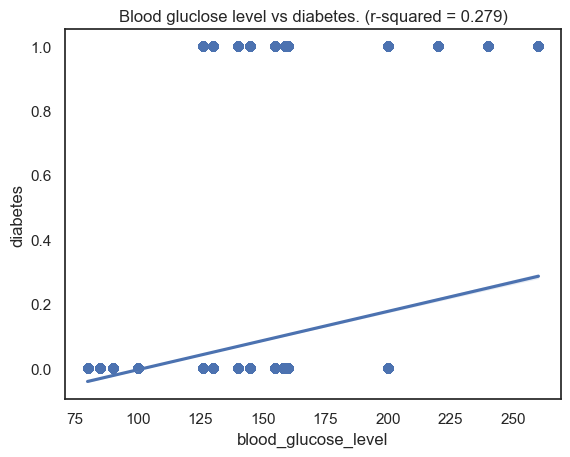

In [ ]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df.blood_glucose_level, df.diabetes)
fig, ax = plt.subplots()
sns.regplot(x='blood_glucose_level', y='diabetes',data=df)
ax.set_title("Blood gluclose level vs diabetes. (r-squared = {:.3f})".format(r_value))
plt.show()

Hemoglobin level captures about 40% of the variation in whether somebody has diabetes. Similarly to blood glucose levels, the trend here is also that higher hemoglobin levels are associated with higher indicidence of diabetes.

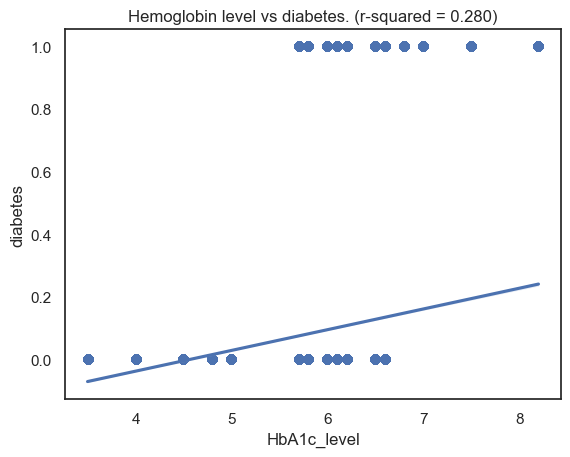

In [ ]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df.HbA1c_level, df.diabetes)
fig, ax = plt.subplots()
sns.regplot(x='HbA1c_level', y='diabetes',data=df)
ax.set_title("Hemoglobin level vs diabetes. (r-squared = {:.3f})".format(r_value))
plt.show()

### *Part 2.4: Interactive Visualizations*
We made dynamic and interactive data visualizations to better understand our data. We begin by comparing age with blood glucose level and we see that young people rarely have very high levels. Our slider lets you visualize this relationship by only considering younger people in the dataset. This visualization is not related to diabetes; it's related to two of the features that are highly predictive of diabetes, and their relationship.

In [ ]:
from matplotlib.widgets import Slider
import ipywidgets as widgets
def update_plot(age_range):
    filtered_data = df[df['age'] <= age_range]
    plt.scatter(filtered_data['age'], filtered_data['blood_glucose_level'], color='blue')
    plt.title('Age vs Blood Glucose Level')
    plt.xlabel('Age')
    plt.ylabel('Blood Glucose Level')
    plt.grid(True)
    plt.show()

age_range_slider = widgets.FloatSlider(
    value=100,
    min=0,
    max=100,
    step=1,
    description='Age Range:',
    continuous_update=False
)

widgets.interactive(update_plot, age_range=age_range_slider)

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Age Range:', step=1.0), O…

Next, we examine the threshold for predicting somebody has diabetes when just considering blood glucose level. Since this feature is one of the two most predictive features in the dataset, using blood glucose level alone is somewhat successful at predicting diabetes. At the threshold 150 mg/dL, which is close to optimal, we classify about 80% of the data points correctly. This shows that, while blood glucose level is a very important feature in our dataset, we need more feature to achieve higher accuracy.

In [ ]:
initial_threshold = 126  # mg/dL

def plot_diabetes_diagnosis_threshold(threshold):
    colors = np.where(df['blood_glucose_level'] >= threshold, 'red', 'blue')

    plt.scatter(df['blood_glucose_level'], df['diabetes'], color=colors)
    plt.axvline(x=threshold, color='gray', linestyle='--')
    plt.title('Blood Glucose Level vs Diabetes')
    plt.xlabel('Blood Glucose Level (mg/dL)')
    plt.ylabel('Diabetes (0: No, 1: Yes)')
    plt.grid(True)
    plt.show()

threshold_slider = widgets.IntSlider(
    value=initial_threshold,
    min=100,
    max=201,
    step=1,
    description='Threshold:',
    continuous_update=False
)

widgets.interactive(plot_diabetes_diagnosis_threshold, threshold=threshold_slider)

interactive(children=(IntSlider(value=126, continuous_update=False, description='Threshold:', max=201, min=100…

Next, we examine the relationship between hemoglobin level, BMI, and diabetes. From this visualziation, we can see that hemoglobin level is much more predictive of diabetes than BMI is. If we use the slider, we can also see that younger people have lower BMI's on average and that older people with mid-range hemoglobin levels are more likely to have diabetes.

In [ ]:
def plot_diabetes_likelihood(age_range):
    filtered_data = df[df['age'] <= age_range]
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_data['HbA1c_level'], filtered_data['bmi'], c=filtered_data['diabetes'], cmap='coolwarm', edgecolors='k', alpha=0.7)
    plt.colorbar(label='Diabetes (0: No, 1: Yes)')
    plt.xlabel('HbA1c Level')
    plt.ylabel('BMI')
    plt.title(f'Diabetes Likelihood (Age <= {age_range})')
    plt.grid(True)
    plt.show()

age_range_slider = widgets.FloatSlider(
    value=100,
    min=20,
    max=100,
    step=1,
    description='Age Range:',
    continuous_update=False
)

widgets.interactive(plot_diabetes_likelihood, age_range=age_range_slider)

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Age Range:', min=20.0, st…

## ***Part 3: Decision Tree Model and Most Significiant Risk Factors Associated with Diabetes***

We will use a decision tree to determine which feature is the most important in determining diabetes.


In [ ]:
# decision tree function
def build_decision_tree(max_depth = None):

    dt = DecisionTreeClassifier(random_state=0, max_depth = max_depth)


    dt.fit(X_train, y_train)


    train_pred_dt = dt.predict(X_train)
    test_pred_dt = dt.predict(X_test)

    print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    dt.score(X_train, y_train), dt.score(X_test, y_test)))
    return dt, dt.score(X_train, y_train), dt.score(X_test, y_test)
dt,train,test = build_decision_tree()

Training Accuracy : 0.9990, Testing Accuracy: 0.9523


From accuracy metrics of the decision tree classifier, it looks like the performance of decision tree classifier is great with our chosen dataset! Training and testing accuracy are both above 95 percent, so we make sure that there is little overfitting happening where training accuracy is much better than testing accuracy. Of course, training accuracy is higher than testing accuracy meaning there is some overfitting, but it is not severe. One limitation of decision trees is they are quite variable and susceptible to changes in data, meaning a new dataset that may include some but not all features used in training may not perform as well as the testing accuracy we have here.

Next, we can look into hyperparameter tuning to choose the best bias-variance balance in the decision tree model. In this case, we look for the most suited max_depth value we could use in order to make representative (in other words, generalizable) observations on which features could be most associated with diabetes and significant in classifying diagnosis of diabetes. In addition, while accuracy is a great measure of how the model performs, we must assess other performance metrics like recall and precision to determine if the model is truly well-adapted for diabetes classification.

### *Part 3.1: Hyperparameter Tuning, Decision Tree Performance, and Feature Importances*

In [ ]:
##finding training and testing accuracies based on different max_depth values from a range of 1 to 51.
training_accuracies=[]
testing_accuracies=[]
for depth in range(1, 51):
    dt, train_acc, test_acc = build_decision_tree(max_depth=depth)
    training_accuracies.append(train_acc)
    testing_accuracies.append(test_acc)

Training Accuracy : 0.9540, Testing Accuracy: 0.9537
Training Accuracy : 0.9722, Testing Accuracy: 0.9707
Training Accuracy : 0.9722, Testing Accuracy: 0.9707
Training Accuracy : 0.9722, Testing Accuracy: 0.9707
Training Accuracy : 0.9722, Testing Accuracy: 0.9707
Training Accuracy : 0.9722, Testing Accuracy: 0.9707
Training Accuracy : 0.9722, Testing Accuracy: 0.9707
Training Accuracy : 0.9723, Testing Accuracy: 0.9707
Training Accuracy : 0.9727, Testing Accuracy: 0.9703
Training Accuracy : 0.9730, Testing Accuracy: 0.9705
Training Accuracy : 0.9735, Testing Accuracy: 0.9700
Training Accuracy : 0.9743, Testing Accuracy: 0.9697
Training Accuracy : 0.9753, Testing Accuracy: 0.9687
Training Accuracy : 0.9768, Testing Accuracy: 0.9681
Training Accuracy : 0.9787, Testing Accuracy: 0.9671
Training Accuracy : 0.9805, Testing Accuracy: 0.9655
Training Accuracy : 0.9825, Testing Accuracy: 0.9645
Training Accuracy : 0.9845, Testing Accuracy: 0.9633
Training Accuracy : 0.9869, Testing Accuracy: 

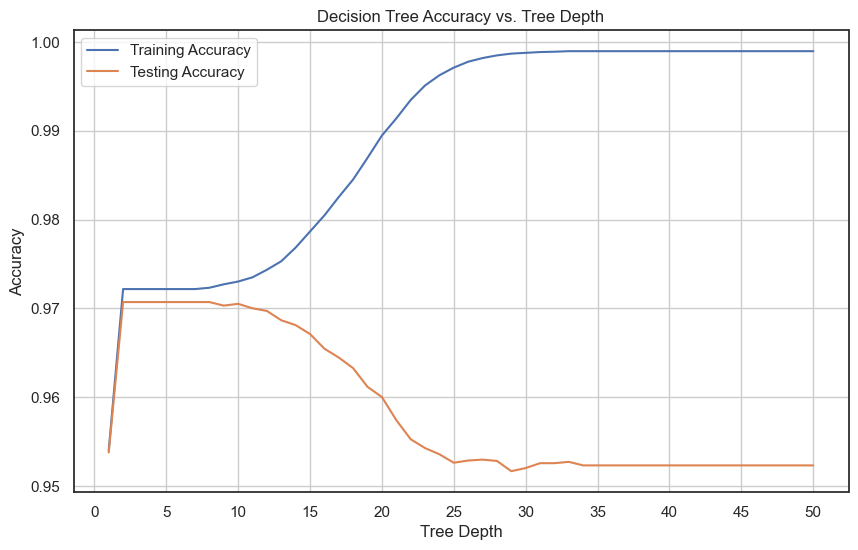

In [ ]:
#let's graph it to better visualize the results!
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), training_accuracies, label='Training Accuracy')
plt.plot(range(1, 51), testing_accuracies, label='Testing Accuracy')
plt.title('Decision Tree Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 51, 5))
plt.show()

Overfitting starts when Tree Depth is 7, since this is where the testing accuracy begins going down and training accuracy is increasingly getting better. From this, we can conclude that 7 is the optimal number max_depth value for a decision tree classifier on our selected dataset.

Now we will determine how the model performs with accuracy, recall, and precision if the max_depth is 7 and identify the most important feature in determining diabetes when using the decision tree model.

We take the maximum feature importance from our previously created decision tree model with max_depth = 7, and find the column name corresponding to this feature. In this case the result is HbA1c_level. This result makes sense since HbA1c is the standardized metric for determining diabetes diagnosis in clinical practice. That is, a doctor decides whether an individual has diabetes or not based on the individual's HbA1c level. While other features may be associated with diabetes, this metric gives an indicator of diabetes.

In [ ]:
dt, training_accuracy, testing_accuracy = build_decision_tree(max_depth = 7)
best_feature_idx = np.argmax(dt.feature_importances_)
best_feature = X.columns[best_feature_idx]
print("The %d-th feature called **%s** is the most importance feature"%(best_feature_idx, best_feature))

Training Accuracy : 0.9722, Testing Accuracy: 0.9707
The 6-th feature called **HbA1c_level** is the most importance feature


In [ ]:
dt = DecisionTreeClassifier(random_state=0, max_depth = 7)
dt.fit(X_train, y_train)
train_pred_dt = dt.predict(X_train)
test_pred_dt = dt.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score
dt_accuracy_training = accuracy_score(y_train, train_pred_dt)
dt_accuracy_test = accuracy_score(y_test, test_pred_dt)
dt_recall_training = recall_score(y_train, train_pred_dt)
dt_recall_test = recall_score(y_test, test_pred_dt)
dt_precision_training =  precision_score(y_train, train_pred_dt)
dt_precision_test = precision_score(y_test, test_pred_dt)

training_metrics = [dt_accuracy_training, dt_recall_training, dt_precision_training]
labels = ['accuracy', 'recall', 'precision']
testing_metrics = [dt_accuracy_test, dt_recall_test, dt_precision_test]

print(f"training metrics are:{training_metrics}")
print(f"testing metrics are: {testing_metrics}")
final_model_performance = []
all_data_finaldtmetrics = np.mean(testing_metrics)
final_model_performance.append(all_data_finaldtmetrics)

training metrics are:[0.9721625, 0.6725, 1.0]
testing metrics are: [0.9707, 0.6552941176470588, 1.0]


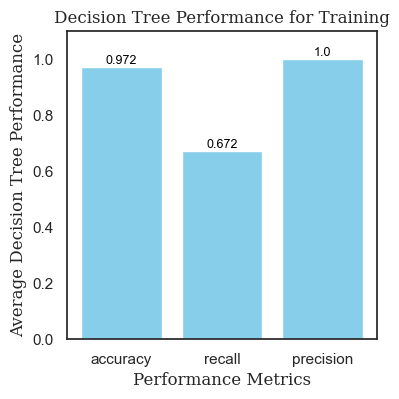

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()


Decision tree training performance is great with accuracy and precision but not with recall. This could be a matter of class imbalance not setting up a proper representation of diabetic patients because there aren't as many entries with diabetes as there are without.

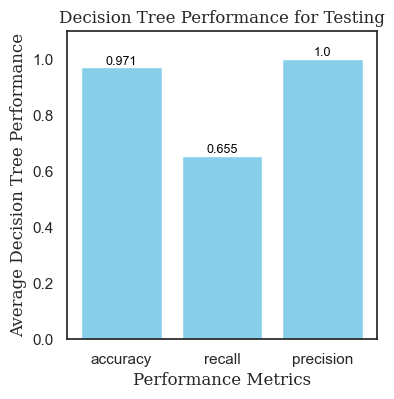

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm_test_dt = confusion_matrix(y_test, test_pred_dt)
cm_test_dt = cm_test_dt.astype('float') / cm_test_dt.sum(axis=1)[:, np.newaxis]
cm_train_dt = confusion_matrix(y_train, train_pred_dt)
cm_train_dt = cm_train_dt.astype('float') / cm_train_dt.sum(axis=1)[:, np.newaxis]

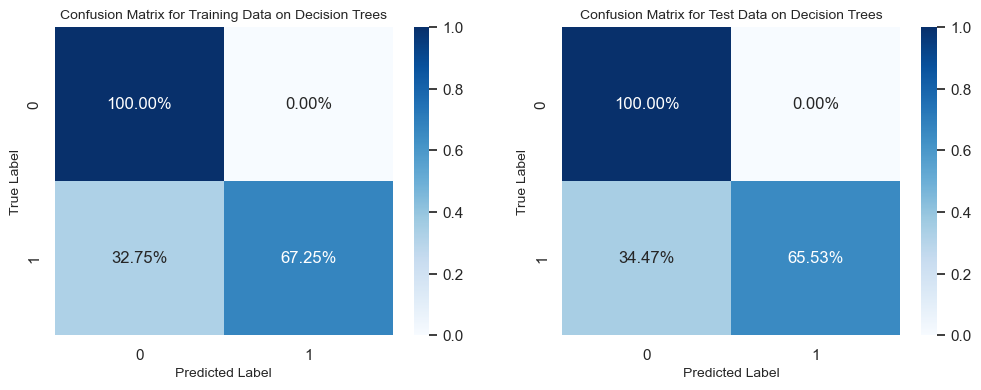

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_train_dt, annot=True, fmt='.2%', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix for Training Data on Decision Trees', fontsize= 10)
ax1.set_xlabel('Predicted Label', fontsize = 10)
ax1.set_ylabel('True Label', fontsize = 10)

sns.heatmap(cm_test_dt, annot=True, fmt='.2%', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix for Test Data on Decision Trees', fontsize = 10)
ax2.set_xlabel('Predicted Label', fontsize = 10)
ax2.set_ylabel('True Label', fontsize = 10)

plt.show()

Decision tree testing performance is similar to training performance which suggests the model is well-fitted, no underfitting or overfitting. Again, recall is low but accuracy and precision are high. Given the distribution of the performance metrics, we can deduce that the decision tree is really good at identify which patients do not have diabetes accurately and precisely but may not be able to identify positive cases of diabetes well. When we compare the confusion matrices for training and testing data, the advantage of this model is that there is consistent performance between training and testing data. Unfortunately, false positive cases are high (bottom left) and true negative cases are on the lower side (bottom right). Perhaps other models would perform better in recall.

We can also observe how important some of the other features in this dataset are for diabetes.

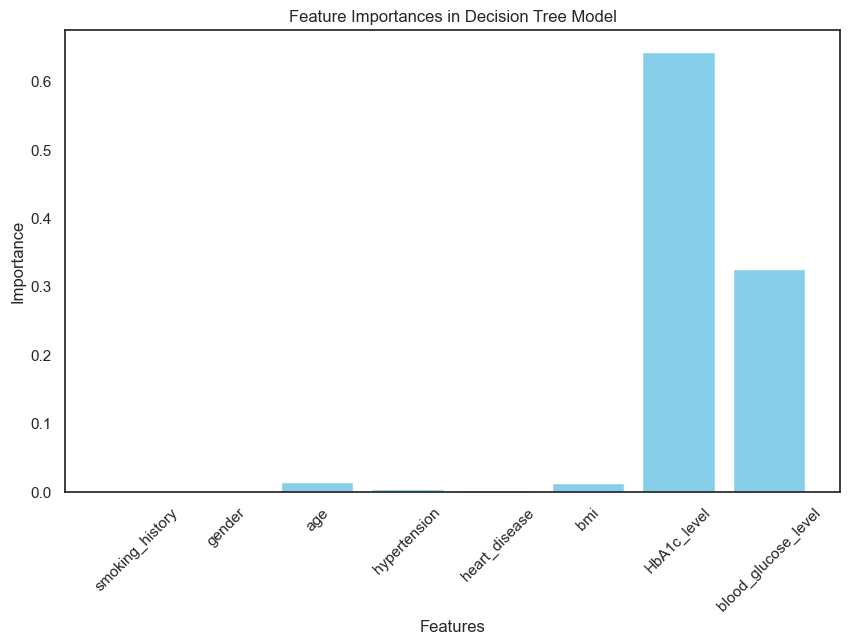

In [ ]:
feature_columns = df.columns
feature_importance = dt.feature_importances_
feature_names = feature_columns[0:8]


plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance, color='skyblue')
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


We can see results are quite skewed for which features are important in classifying diabetes. Are the other features necessary to produce a successful classifier? We can explore in the next section how many features in this dataset are necessary to train an effective classifier, and if other model architectures can perform better than the decision tree model.

## ***Part 4: Training and Evaluation of Other Classifiers***

How will other model architectures perform for diagnosing diabetes? In the following section, we explore and compare the performance of logistic regression classification and random forests to decision trees. Since the diagnosis of diabetes is based off of HbA1c levels, we hypothesize the decision tree model would be most suited as it gives a simple binary condition for the task. That is, if a certain threshold of HbA1c is crossed, the individial has diabetes, if it isn't, then the individual doesn't have diabetes. Models like logisitic regression may get complicated with the levels of feature dimensions we have in the dataset.

### *Part 4.1: Logistic Regression, Weighted Logistic Regression and Respective Model Performances*

 We will use LogisticRegression to see if that is a good model

In [ ]:
logreg = LogisticRegression()

#it has been scaled and cleaned before so we can just feed in the train and test

#fit to the logisticRegression
logreg.fit(X_train, y_train)

#predict
train_pred = logreg.predict(X_train)
test_pred = logreg.predict(X_test)

In [ ]:
#check the scores of the models

# Get Training Accuracy
logreg.score(X_train, y_train)

0.9598875

In [ ]:
#Get testing accuracy
logreg.score(X_test, y_test)

0.96105

At first glance, it looks like LogisticRegression is also a good model when comparing test and training accuracy. There is little to no overfitting and it also has a high accuracy of 95%+ on both the training and testing. We can consider alternative approaches to optimizing this model for our dataset, the first being weighted logistic regression, meaning classes of diabetes and no diabetes will get balanced. In **Part 2** we learned that our dataset has a disproportionate amount of individuals with and without diabetes. Balancing classes could give a more representative logistic regression model. Let's compare a weighted logistic regression model with a nonweighted model using accuracy, recall, and precision scores.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
lrg = LogisticRegression()

weighted_lrg = LogisticRegression(class_weight='balanced')
lrg.fit(X_train, y_train)
weighted_lrg.fit(X_train, y_train)
y_train_pred_lrg = lrg.predict(X_train)
y_test_pred_lrg = lrg.predict(X_test)

y_train_pred_weighted_lrg = weighted_lrg.predict(X_train)
y_test_pred_weighted_lrg = weighted_lrg.predict(X_test)
lrg_train_acc = accuracy_score(y_train, y_train_pred_lrg)
lrg_test_acc = accuracy_score(y_test, y_test_pred_lrg)
lrg_train_rec = recall_score(y_train, y_train_pred_lrg)
lrg_test_rec = recall_score(y_test, y_test_pred_lrg)
lrg_train_pre = precision_score(y_train, y_train_pred_lrg)
lrg_test_pre = precision_score(y_test, y_test_pred_lrg)


weighted_lrg_train_acc = accuracy_score(y_train, y_train_pred_weighted_lrg)
weighted_lrg_test_acc = accuracy_score(y_test, y_test_pred_weighted_lrg)
weighted_lrg_train_rec = recall_score(y_train, y_train_pred_weighted_lrg)
weighted_lrg_test_rec = recall_score(y_test, y_test_pred_weighted_lrg)
weighted_lrg_train_pre =  precision_score(y_train, y_train_pred_weighted_lrg)
weighted_lrg_test_pre = precision_score(y_test, y_test_pred_weighted_lrg)

In [ ]:

print('Regular Logistic Regression Performance')
print('---------------------------------------')
print(f'Training Accuracy: {lrg_train_acc*100:.2f}%')
print(f'Testing Accuracy: {lrg_test_acc*100:.2f}%')
print(f'Training Recall: {lrg_train_rec*100:.2f}%')
print(f'Testing Recall: {lrg_test_rec*100:.2f}%')
print(f'Training Precision: {lrg_train_pre*100:.2f}%')
print(f'Testing Precision: {lrg_test_pre*100:.2f}%')

print()

print('Class Weighted Logistic Regression Performance')
print('----------------------------------------------')
print(f'Training Accuracy: {weighted_lrg_train_acc*100:.2f}%')
print(f'Testing Accuracy: {weighted_lrg_test_acc*100:.2f}%')
print(f'Training Recall: {weighted_lrg_train_rec*100:.2f}%')
print(f'Testing Recall: {weighted_lrg_test_rec*100:.2f}%')
print(f'Training Precision: {weighted_lrg_train_pre*100:.2f}%')
print(f'Testing Precision: {weighted_lrg_test_pre*100:.2f}%')


Regular Logistic Regression Performance
---------------------------------------
Training Accuracy: 95.99%
Testing Accuracy: 96.10%
Training Recall: 62.51%
Testing Recall: 62.88%
Training Precision: 86.56%
Testing Precision: 87.84%

Class Weighted Logistic Regression Performance
----------------------------------------------
Training Accuracy: 88.70%
Testing Accuracy: 88.75%
Training Recall: 88.04%
Testing Recall: 87.47%
Training Precision: 42.13%
Testing Precision: 42.21%


Weighted logistic regression performance goes down if we look at accuracy and precision but increases if we look at recall. This makes sense because class balance with the weighted model allows there to be equal representation of positive and negative cases. It is easier to differentiate between diabetes-positive and diabetes-negative patients. However, accuracy and precision are poor. When we look at accuracy, it is a measure of how many times the model can correctly identify the class. If a model is highly imbalanced, it will be really good at identifying the major class as it would learn the most on the majority class. Yet, this isn't representative for identifying the minority class which is why ultimately the less accurate, less precise model would be the preferrable choice (since we want to make sure patients with diabetes are going to be diagnosed properly).  

In [ ]:
lrg_training_metrics = [lrg_train_acc, lrg_train_rec, lrg_train_pre]
labels = ['accuracy', 'recall', 'precision']
lrg_testing_metrics = [lrg_test_acc, lrg_test_rec, lrg_test_pre]
all_data_lrgtest = np.mean(lrg_testing_metrics)
final_model_performance.append(all_data_lrgtest)

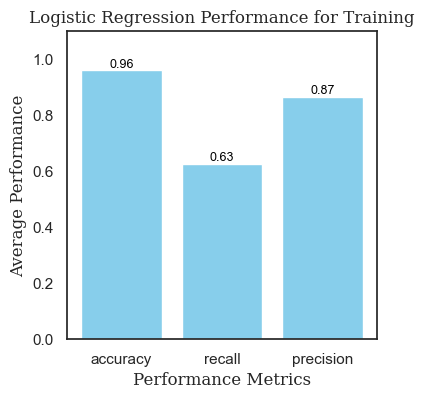

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, lrg_training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Logistic Regression Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

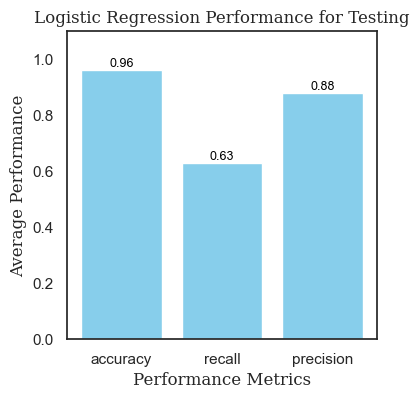

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, lrg_testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Logistic Regression Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

In [ ]:
wlrg_training_metrics = [weighted_lrg_train_acc, weighted_lrg_train_rec, weighted_lrg_train_pre]
labels = ['accuracy', 'recall', 'precision']
wlrg_testing_metrics = [weighted_lrg_test_acc, weighted_lrg_test_rec, weighted_lrg_test_pre]
all_data_wlrgtest = np.mean(wlrg_testing_metrics)
final_model_performance.append(all_data_wlrgtest)

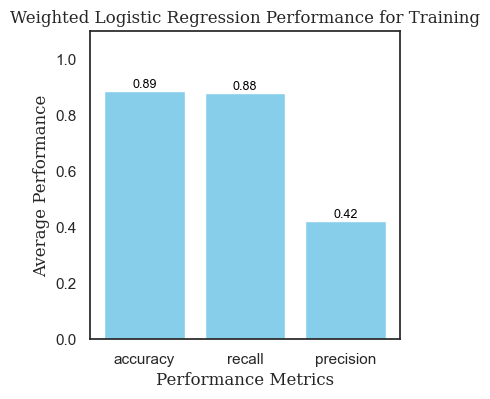

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, wlrg_training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Weighted Logistic Regression Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

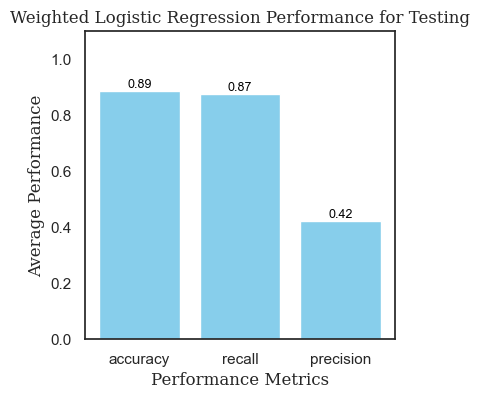

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, wlrg_testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Weighted Logistic Regression Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

The weighted logistic regression model decreases in accuracy and especially precision compared to the non-weighted or standard logistic regression model. However, note how recall has increased in performance now. Class-balance achieves better recall which is necessary for proper classification of diabetes from the features available in this dataset.

Below, we show the confusion matrices for training and testing data on weighted and traditional logistic regression. Initially, it looks like the true positive rate is quite good in logistic regression (top left) but then the true negative rate isn't so good (bottom right). This means there is poor specificity in the model and there are more false positives. However, when you look at the weighted logistic regression while true positive decreases, false positives also decreases bringing true negative higher!

In [ ]:
cm_test_lrg = confusion_matrix(y_test, y_test_pred_lrg)
cm_test_lrg = cm_test_lrg.astype('float') / cm_test_lrg.sum(axis=1)[:, np.newaxis]
cm_train_lrg = confusion_matrix(y_train, y_train_pred_lrg)
cm_train_lrg = cm_train_lrg.astype('float') / cm_train_lrg.sum(axis=1)[:, np.newaxis]
cm_train_wlrg = confusion_matrix(y_train, y_train_pred_weighted_lrg)
cm_train_wlrg = cm_train_wlrg.astype('float') / cm_train_wlrg.sum(axis=1)[:, np.newaxis]
cm_test_wlrg = confusion_matrix(y_test, y_test_pred_weighted_lrg)
cm_test_wlrg = cm_test_wlrg.astype('float') / cm_test_wlrg.sum(axis=1)[:, np.newaxis]

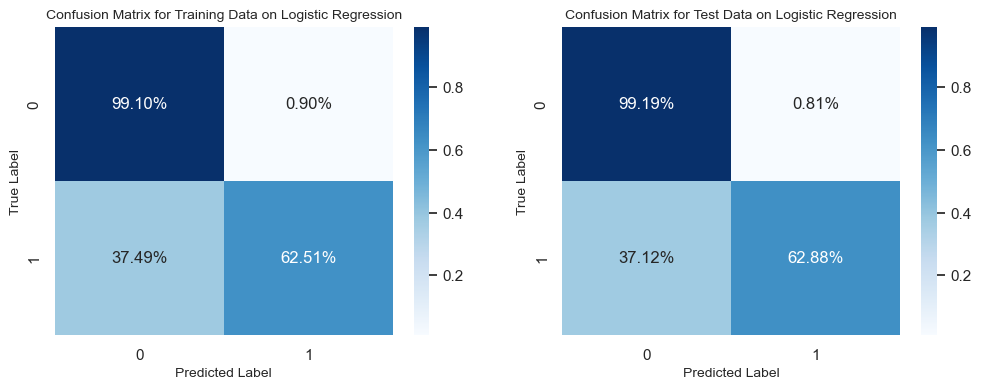

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_train_lrg, annot=True, fmt='.2%', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix for Training Data on Logistic Regression', fontsize= 10)
ax1.set_xlabel('Predicted Label', fontsize = 10)
ax1.set_ylabel('True Label', fontsize = 10)

sns.heatmap(cm_test_lrg, annot=True, fmt='.2%', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix for Test Data on Logistic Regression', fontsize = 10)
ax2.set_xlabel('Predicted Label', fontsize = 10)
ax2.set_ylabel('True Label', fontsize = 10)

plt.show()

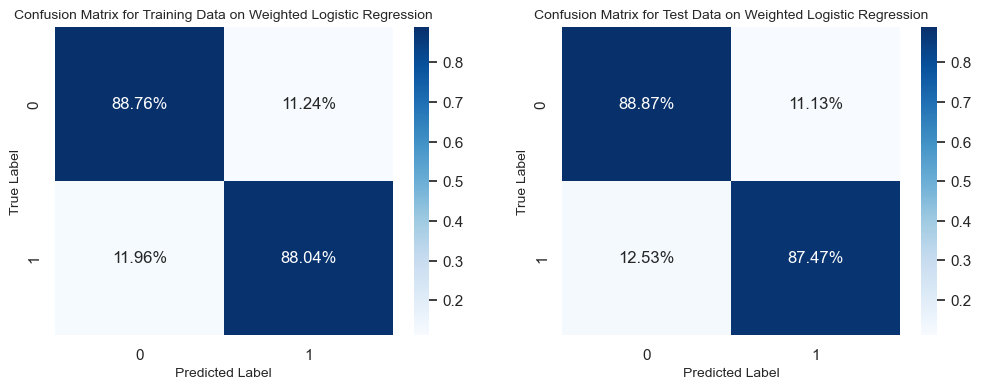

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_train_wlrg, annot=True, fmt='.2%', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix for Training Data on Weighted Logistic Regression', fontsize= 10)
ax1.set_xlabel('Predicted Label', fontsize = 10)
ax1.set_ylabel('True Label', fontsize = 10)

sns.heatmap(cm_test_wlrg, annot=True, fmt='.2%', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix for Test Data on Weighted Logistic Regression', fontsize = 10)
ax2.set_xlabel('Predicted Label', fontsize = 10)
ax2.set_ylabel('True Label', fontsize = 10)

plt.show()

### *Part 4.1.2: Hyperparameter Tuning on Weighted Logistic Regression*

The weighted logistic regression improved our recall score but decreased accuracy and precision. Accuracy isn't too low compared to recall, but precision has dramatically decreased. Can we train a logistic regression that is class-weighted and has a good precision score? Below we explore hyperparameter tuning with a 5 fold split to see what happens if we change the learning rate on a class-weighted logistic regression model. The learning rate is associated with the step size at which parameters are optimized. A slow learning rate is often computationally expensive and a learning rate that is too fast will probably diverge from the path to convergence. This optimal learning rate of course varies between model family and dataset distributions. As such, we choose a range of 0.01 to 1.0 to test which learning rate is the optimal for our problem.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
seed = 12345
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define the Logistic Regression classification model/estimator
estimator = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000)

# Define the hyperparameter search space/grid
param_grid = {
    'C': [0.01, 0.1, 0.25, 0.50, 0.75, 1.0]

}

# Define the metric as a lower case string (for example: scoring = 'accuracy')
scoring = 'precision'

search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=2)

search.fit(X_train, y_train)

y_test_pred = search.best_estimator_.predict(X_test)
search_score = precision_score(y_test, y_test_pred)

print(f'The best Logistic Regression model has hyperparameters {search.best_params_}')
print(f'The best model achieves an average cross-validation score of {search.best_score_*100:.2f}%')
print(f'The best model achieves a precision score of {search_score*100:.2f}% on the testing data')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END .............................................C=0.25; total time=   0.2s
[CV] END ........................................

When logistic regression is weighted for class balance, precision is bound to decrease. Hyperparameter tuning in this case did not improve precision unfortunately. This suggests that there could be high variance in the model when testing data is inputted. Particularly, the output of the model changes upon seeing similar data. We continue further model explorations to see if we can achieve a balance between good recall, accuracy and precision as all three are important in having a successful classifier.

### *Part 4.2: Random Forests Model and Performance*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model on your data
model.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [ ]:
#let's see how good the model is
from sklearn.metrics import accuracy_score
# Make predictions on the training data and the testing data
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate the accuracy for the training data and the testing data
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Print out the accuracy scores
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9989625
Testing Accuracy: 0.96835


In [ ]:
cm_test_rf = confusion_matrix(y_test, test_predictions)
cm_test_rf = cm_test_rf.astype('float') / cm_test_rf.sum(axis=1)[:, np.newaxis]
cm_train_rf = confusion_matrix(y_train, train_predictions)
cm_train_rf = cm_train_rf.astype('float') / cm_train_rf.sum(axis=1)[:, np.newaxis]

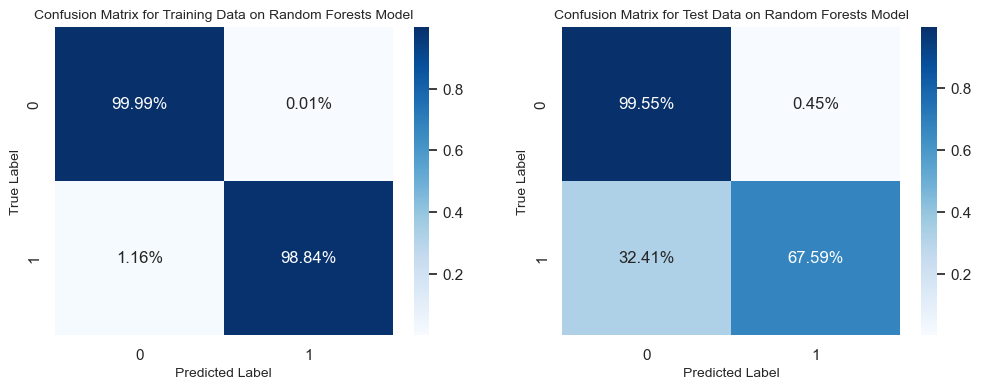

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm_train_rf, annot=True, fmt='.2%', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix for Training Data on Random Forests Model', fontsize= 10)
ax1.set_xlabel('Predicted Label', fontsize = 10)
ax1.set_ylabel('True Label', fontsize = 10)

sns.heatmap(cm_test_rf, annot=True, fmt='.2%', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix for Test Data on Random Forests Model', fontsize = 10)
ax2.set_xlabel('Predicted Label', fontsize = 10)
ax2.set_ylabel('True Label', fontsize = 10)

plt.show()

In [ ]:
rf_train_acc = accuracy_score(y_train, train_predictions)
rf_test_acc = accuracy_score(y_test, test_predictions)
rf_train_rec = recall_score(y_train, train_predictions)
rf_test_rec = recall_score(y_test, test_predictions)
rf_train_pre =  precision_score(y_train, train_predictions)
rf_test_pre = precision_score(y_test, test_predictions)
rf_training_metrics = [rf_train_acc, rf_train_rec, rf_train_pre]
labels = ['accuracy', 'recall', 'precision']
rf_testing_metrics = [rf_test_acc, rf_test_rec, rf_test_pre]
all_data_rftest = np.mean(rf_testing_metrics)
final_model_performance.append(all_data_rftest)

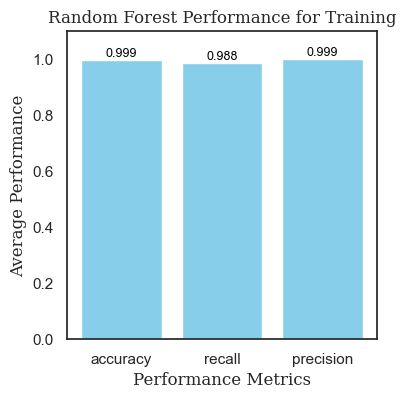

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, rf_training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Random Forest Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

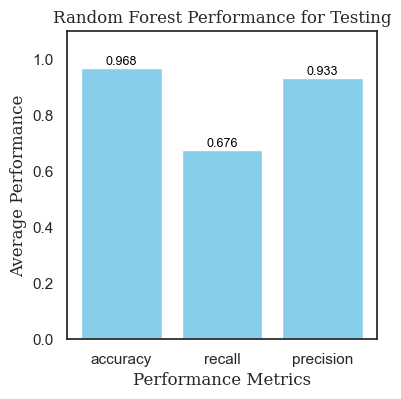

In [ ]:
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, rf_testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Random Forest Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

It looks like random forests are similar in performance with decision trees in training accuracy and testing. Similar to the unweighted logistic regression model, the confusion matrix is not quite as good for testing data. However, the training data is well represented between true positives and true negatives.  Yet, recall decreases significantly in testing predictions compared training predictions which suggests there is overfitting in the random forests model. While this is peculiar after seeing the results of the training performance, when we consider how random forest models work by ensembling decision trees to improve performances we know there are various forms of overfitting in each tree. Unfortunately, like the decision tree model, if there isn't good recall, it cannot be deemed a successful classifier for diabetes where the inherent mission is to be able to get true positives without getting to many false positives.

### *Part 4.2.2: Hyperparameter Tuning on Random Forests*

Hyperparameter tuning on random forests gives us the flexibility to expand decision tree max depth since the simple act of ensembling many trees helps us prevent overfitting. As such we explore two hyperparameters: n estimators and max_depth strategically using grid search.

In [ ]:
seed = 12345
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define the model
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [None, 2, 5, 7, 10],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='recall', verbose=2, n_jobs= -1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.0s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END .....................max_depth=None, n_estimators=3; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=30; total time=   1.2s
[CV] END ....................max_depth=None, n_e

We can improve recall to about 71% if we don't set a max_depth and have an n_estimators of 3. Our initial model was trained on 100 n_estimators but it looks like decreasing this can improve the model performance. We chose not to proceed with this because testing and training accuracy are already very good the original random forests model and recall was actually higher before as well.

### *Part 4.3: Unsupervised Clustering with K-Means*

K-Means can give us insights into how data is distributed based on different features in our dataset. It is a form of unsupervised learning, not traditionally used for classification but allows mapping of our dataset. Thus far, we've determined HbA1c levels are a very important factor in classifying diabetes. Can we look at how our training data is distributed for the next two most important features (ie. blood glucose level and bmi)? How many overarching groups or clusters would be ideal to represent these factors? Below we test a few different cluster sizes in a K-Means algorithm to find how many clearly divided groups are present in our dataset when we compare BMI and blood_glucose levels, starting with 2 and going up to 7 (the amount of features in our dataset).

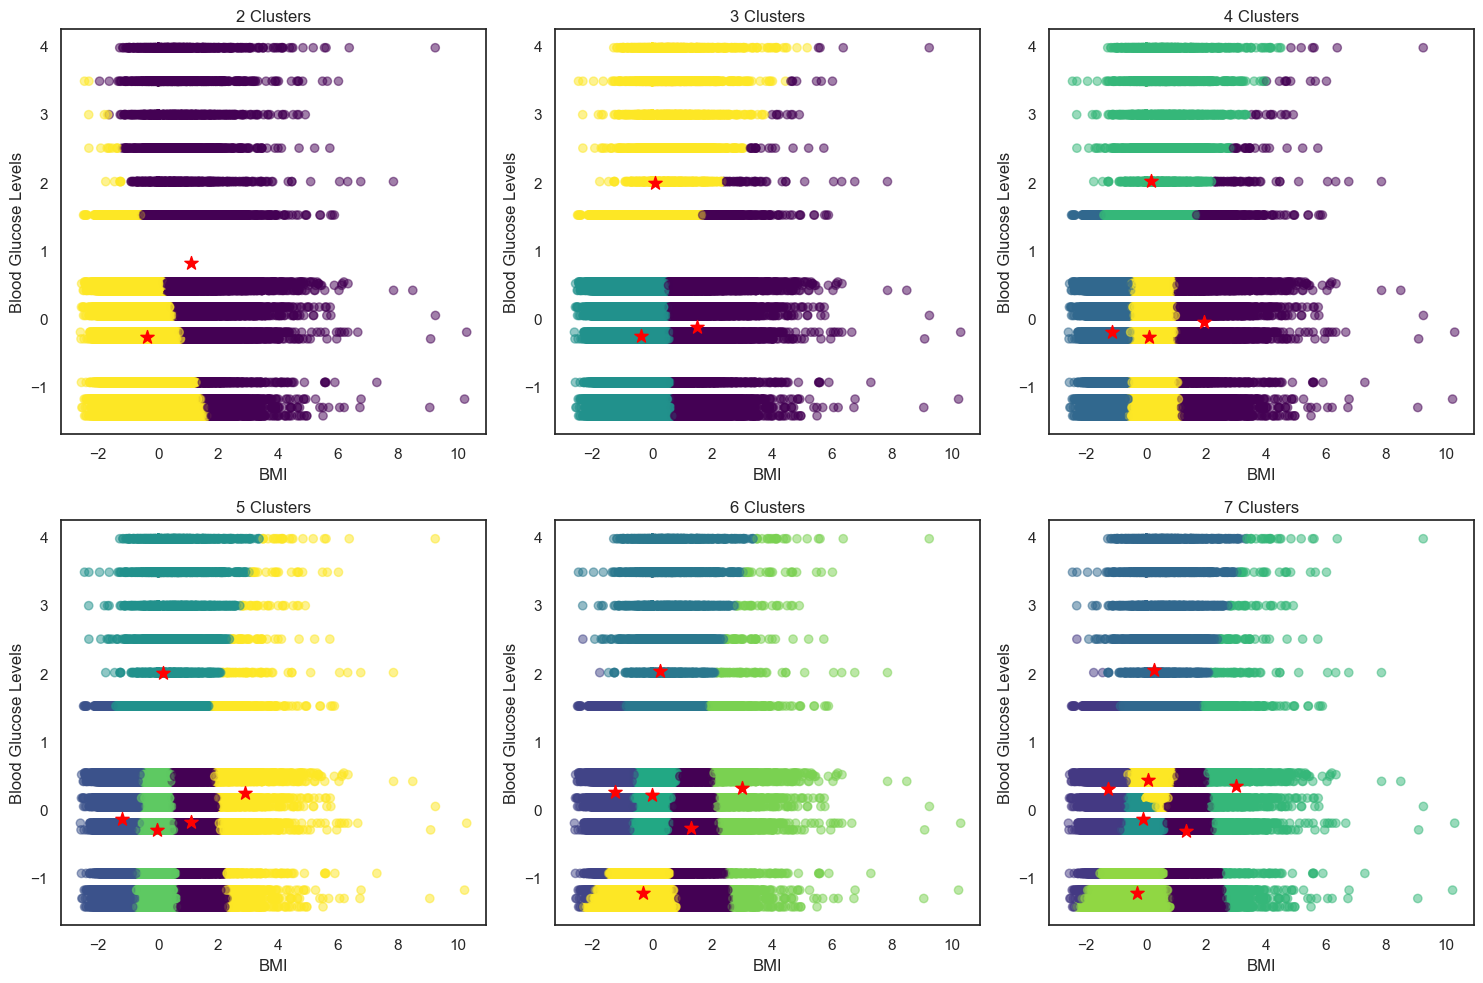

In [ ]:
from sklearn.cluster import KMeans
cluster_sizes = [2, 3, 4, 5, 6, 7]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
scaler = StandardScaler()

X_train_kmeans = scaler.fit_transform(X_train[:, [5, 7]])
for i, k in enumerate(cluster_sizes):
    kmeans = KMeans(n_init= 'auto', n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(X_train_kmeans)

    axs[i].scatter(X_train_kmeans[:,0], X_train_kmeans[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    axs[i].set_title(f'{k} Clusters')
    axs[i].set_xlabel('BMI')
    axs[i].set_ylabel('Blood Glucose Levels')
    centers = scaler.transform(kmeans.cluster_centers_)
    axs[i].scatter(centers[:, 0], centers[:, 1], s=100, c='red', marker='*')

plt.tight_layout()
plt.show()


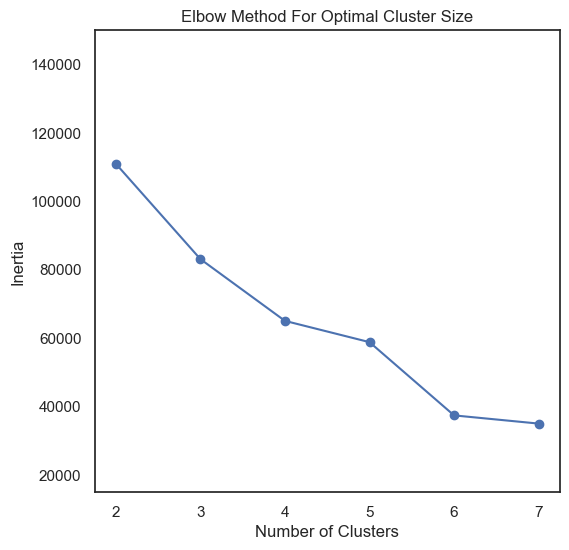

In [ ]:
##what is our ideal cluster size in this dataset? Will use a plotting of distortion vs number of clusters to see where the ideal point is (where the elbow is)
inertias = []
for i, k in enumerate(cluster_sizes):
    kmeans = KMeans(n_init = 'auto', n_clusters=k, random_state=0)
    kmeans.fit(X_train_kmeans)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(cluster_sizes, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Cluster Size')
plt.ylim(15000, 150000)
plt.show()

According to the distortion vs. number of clusters plot we can determine that about 3-6 clusters would be the ideal option for data clustering for this dataset. This is interesting because our dataset has seven features which is more than the amount of clusters that seem ideal in K-means plotting. It is possible that ideal diabetes classification is related to combination of features rather than individual features. From the K-means plots we can see as cluster size increases the BMI range is the most variable for the clusters vs the blood glucose level. Blood glucose divisions remain about the same despite changes in cluster sizes, where below a certain amount is always classified as one cluster and above the threshold is classified as another. Qualititatively, mapping with three clusters makes the most sense since it clearly shows there is a group of people who are definitely diabetic if they cross a certain BMI and blood glucose level threshold. Similarly, when patients are below a certain BMI classification of diabetes is mostly based on blood glucose level. Now, we omitted HbA1c levels but isn't blood glucose levels the same? How could it show anything different? In fact, HbA1c levels show glucose metabolism for past 2-3 months while blood glucose shows us an immediate result. Blood glucose levels can be variable in even non-diabetic patients based on the time of the day and the time of their last meal. It's much less indicative in clinical practice, but its measure isn't so dependent on a doctor visit. There are devices that could look at blood-glucose and BMI in your own home, which is why assessing their importances and behavior in relation to diabetes classification is even more crucial in determining if patients could be pre-disposed to diabetes and may want to consider a check up.

## ***Part 5: Additional Model and Training Data Explorations***

Hemoglobin level is not something easily accessible to the general public. To get hemoglobin level, most people need to go to a doctor anyways, defeating the purpose of a  usable machine learning model. In this section, we will explore what happens if hemoglobin level and glucose level are not used, and if the resulting model would still be accurate predictng diabetes.

### *Part 5.1: Training with no HbA1c levels*

We will first explore how accurate the model would be if there is no hemoglobin level within the features data. Without the most important feature, what would happen to the accuracy of the model? First we start with a decision tree model and then proceed with an ensembling using random forests. There is a trade-off between using the best parameters for our data and using a model that isn't overfitting. Yet, we strategically perform a max depth mapping with training and testing accuracy to see where the best training accuracy is before testing accuracy diverges.

In [ ]:
#remove the hemoglobin level into its own df
no_hemo_df = df[["smoking_history", "gender", "age", "hypertension", "heart_disease", "bmi", "blood_glucose_level", "diabetes"]]
no_hemo_df.head(2)

,smoking_history,gender,age,hypertension,heart_disease,bmi,blood_glucose_level,diabetes
0,1.0,1.0,80.0,0,1,25.19,140,0
1,0.0,1.0,54.0,0,0,27.32,80,0


In [ ]:
#separate into X and y for training
scaler = StandardScaler()
X3=no_hemo_df.loc[:, no_hemo_df.columns != 'diabetes']
y3=df['diabetes']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=12345, stratify=y3, shuffle=True)
cols=["smoking_history", "gender", "age", "hypertension", "heart_disease", "bmi", "blood_glucose_level"]
X3_train[cols] = scaler.fit_transform(X3_train[cols])
X3_test[cols] = scaler.transform(X3_test[cols])

X3_train=np.array(X3_train)
y3_train=np.array(y3_train)
X3_test=np.array(X3_test)
y3_test=np.array(y3_test)

We want to first make a decision tree to see the immediate result of the model when we remove the hemoglobin level from the data.

In [ ]:
# decision tree function
def build_decision_tree(max_depth = None):

    dt = DecisionTreeClassifier(random_state=0, max_depth = max_depth)


    dt.fit(X3_train, y3_train)


    train_pred_dt = dt.predict(X3_train)
    test_pred_dt = dt.predict(X3_test)

    print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    dt.score(X3_train, y3_train), dt.score(X3_test, y3_test)))
    return dt, dt.score(X3_train, y3_train), dt.score(X3_test, y3_test)
dt,train,test = build_decision_tree()

Training Accuracy : 0.9946, Testing Accuracy: 0.9273


This is the first time we see overfitting! Training accuracy is higher than the testing accuracy, but still has a pretty high accuracy. We will look at other tree depths and see if there is an optimal tree depth to prevent overfitting.

In [ ]:
##finding training and testing accuracies based on different max_depth values from a range of 1 to 51.
training_accuracies=[]
testing_accuracies=[]
for depth in range(1, 51):
    dt, train_acc, test_acc = build_decision_tree(max_depth=depth)
    training_accuracies.append(train_acc)
    testing_accuracies.append(test_acc)

Training Accuracy : 0.9566, Testing Accuracy: 0.9566
Training Accuracy : 0.9566, Testing Accuracy: 0.9566
Training Accuracy : 0.9566, Testing Accuracy: 0.9566
Training Accuracy : 0.9566, Testing Accuracy: 0.9566
Training Accuracy : 0.9566, Testing Accuracy: 0.9565
Training Accuracy : 0.9567, Testing Accuracy: 0.9554
Training Accuracy : 0.9569, Testing Accuracy: 0.9562
Training Accuracy : 0.9574, Testing Accuracy: 0.9560
Training Accuracy : 0.9578, Testing Accuracy: 0.9560
Training Accuracy : 0.9585, Testing Accuracy: 0.9551
Training Accuracy : 0.9592, Testing Accuracy: 0.9544
Training Accuracy : 0.9607, Testing Accuracy: 0.9539
Training Accuracy : 0.9627, Testing Accuracy: 0.9524
Training Accuracy : 0.9651, Testing Accuracy: 0.9509
Training Accuracy : 0.9677, Testing Accuracy: 0.9495
Training Accuracy : 0.9701, Testing Accuracy: 0.9476
Training Accuracy : 0.9731, Testing Accuracy: 0.9449
Training Accuracy : 0.9763, Testing Accuracy: 0.9432
Training Accuracy : 0.9792, Testing Accuracy: 

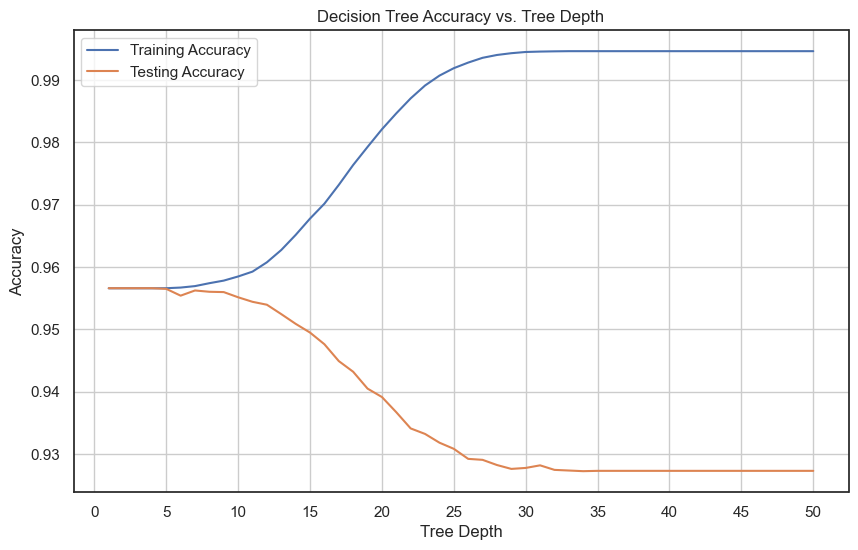

In [ ]:
#plotting the different tree depths
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), training_accuracies, label='Training Accuracy')
plt.plot(range(1, 51), testing_accuracies, label='Testing Accuracy')
plt.title('Decision Tree Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 51, 5))
plt.show()

We can clearly see that after the 5th tree depth, there is overfitting. Therefore, our most optimal tree depth is 5. In a decision tree model without hemoglobin which is the most important feature? Below we use max_depth of 5 to fit a decision tree model and give feature importances.

In [ ]:
dt, training_accuracy, testing_accuracy = build_decision_tree(max_depth = 5)
best_feature_idx = np.argmax(dt.feature_importances_)
best_feature = X3.columns[best_feature_idx]
print("The %d-th feature called **%s** is the most importance feature"%(best_feature_idx, best_feature))

Training Accuracy : 0.9566, Testing Accuracy: 0.9565
The 6-th feature called **blood_glucose_level** is the most importance feature


We see that there is no more overfitting, and it came out to 94% accuracy. This means that the model is still very accurate and we found the tree depth for optimal accuracy.

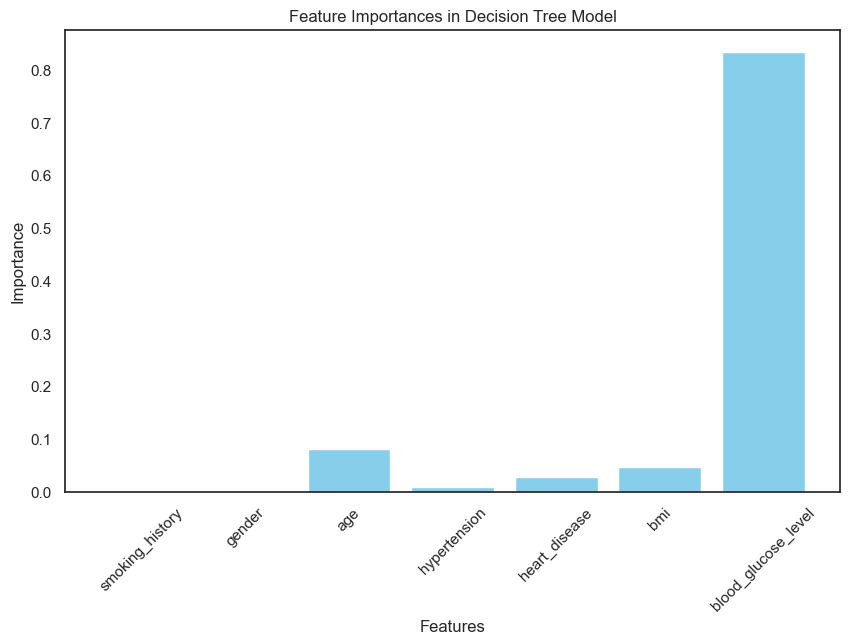

In [ ]:
feature_columns = no_hemo_df.columns
feature_importance = dt.feature_importances_
feature_names = feature_columns[0:7]


plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance, color='skyblue')
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


As expected, the second most important feature is the blood glucose level, and in this chart we see that blood glucose level is a very high determinator of diabetes.

In [ ]:
#getting our accuracy, recall, and precision numbers
train_pred_dt = dt.predict(X3_train)
test_pred_dt = dt.predict(X3_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score
dt_accuracy_training = accuracy_score(y3_train, train_pred_dt)
dt_accuracy_test = accuracy_score(y3_test, test_pred_dt)
dt_recall_training = recall_score(y3_train, train_pred_dt)
dt_recall_test = recall_score(y3_test, test_pred_dt)
dt_precision_training =  precision_score(y3_train, train_pred_dt)
dt_precision_test = precision_score(y3_test, test_pred_dt)

training_metrics = [dt_accuracy_training, dt_recall_training, dt_precision_training]
labels = ['accuracy', 'recall', 'precision']
testing_metrics = [dt_accuracy_test, dt_recall_test, dt_precision_test]
noHbA1c_dttest = np.mean(testing_metrics)
final_model_performance.append(noHbA1c_dttest)


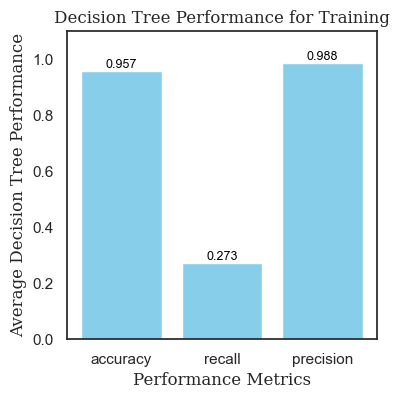

In [ ]:
#plotting our numbers
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

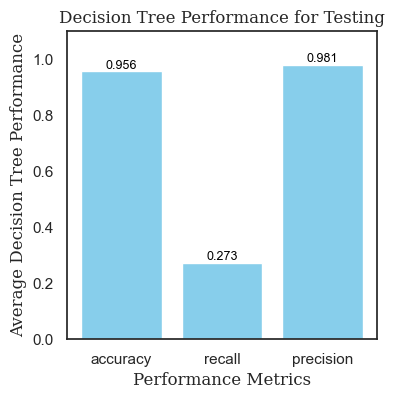

In [ ]:
#plotting our numbers for testing
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

Recall metrics in the decision tree model are not very good for training or testing once we remove HbA1c levels. Accuracy and precision are maintained but this is a problem that we can consider addressing with random forests ensembling.

### *Part 5.2: Finding Optimal Model with Hyperparameter Training*

We will combine random forest ensembling with grid search in max_depth and n_estimators to make the optimal model for our data. Using random forests of a fixed amount of trees prevents variance from getting too high by averaging results from many trees, which gives us some flexibility on max_depth of the trees. These are a few reasons why we focus on these parameters for grid search.

We see that even though the accuracy is very high, recall is very low. When predicitng diabetes, recall is a very important factor to amke sure that everyone that is at risk of diabetes are correctly diagnosed. We will need to optimize for the recall performance.

In [ ]:
seed = 12345
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define the model
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [None, 2, 5, 7, 10],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='recall', verbose=2, n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X3_train, y3_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


KeyboardInterrupt: 

In [ ]:
#getting our accuracy, recall, and precision numbers
rf_best = RandomForestClassifier(n_estimators=3, max_depth = None)
rf_best.fit(X3_train, y3_train)
train_pred_rf = rf_best.predict(X3_train)
test_pred_rf = rf_best.predict(X3_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score
rf_accuracy_training = accuracy_score(y3_train, train_pred_rf)
rf_accuracy_test = accuracy_score(y3_test, test_pred_rf)
rf_recall_training = recall_score(y3_train, train_pred_rf)
rf_recall_test = recall_score(y3_test, test_pred_rf)
rf_precision_training =  precision_score(y3_train, train_pred_rf)
rf_precision_test = precision_score(y3_test, test_pred_rf)

training_metrics = [rf_accuracy_training, rf_recall_training, rf_precision_training]
labels = ['accuracy', 'recall', 'precision']
testing_metrics = [rf_accuracy_test, rf_recall_test, rf_precision_test]
noHbA1c_rftest = np.mean(testing_metrics)
final_model_performance.append(noHbA1c_rftest)

We will now plot the results of the new model after grid search

In [ ]:
#plotting our numbers
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average  Performance', family='serif', fontsize = 12)
plt.title('Tuned Random Forest Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

In [ ]:
#plotting our numbers
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Random Forests Performance', family='serif', fontsize = 12)
plt.title('Tuned Random Forests Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

Even with the best parameters for the random forests there is little overfitting with the recall and precision. However, it is important to remember we've removed the most important feature in the original model and we're still getting better than change results. This suggests that the random forests model could be suited for a classifier if people have the features included in this model at hand. Before we mentioned, blood glucose levels are able to be measured with various devices in the comfort of people's homes. However, in practice, most people do not keep track of their blood glucose. Can we train a model that doesn't see blood glucose level and determines if a person could possibly have diabetes?
We will need a better model to get a better prediction. This is where perhaps neural networks may perform better. Neural networks can learn not so intuitive features on a given dataset, and this is what we will need when we've removed the gold-standard diabetes determining features: blood glucose levels and HbA1c levels.

### *Part 5.3 Training with No HbA1c Nor Blood Glucose Levels.*

We see that Hemoglobin and blood glucose levels were very crucial factors in determing diabetes in the first dataset. Yet not everyone has devices at home to measure blood glucose levels. Can we train a classifier without hemoglobin and blood glucose levels? Below we start with decision tree models, find very poor recall, move to random forests and hyperparameter tuning before deciding finally to resort to neural networks for better model performance.

In [ ]:
##setting up dataset without HbA1c and Blood glucose levels
no_hemo_no_glu_df = df[["smoking_history", "gender", "age", "hypertension", "heart_disease", "bmi","diabetes"]]
no_hemo_no_glu_df.head(2)

X4=no_hemo_no_glu_df.loc[:, no_hemo_no_glu_df.columns != 'diabetes']
y4=df['diabetes']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=12345, stratify=y3, shuffle=True)
cols=["smoking_history", "gender", "age", "hypertension", "heart_disease", "bmi"]
X4_train[cols] = scaler.fit_transform(X4_train[cols])
X4_test[cols] = scaler.transform(X4_test[cols])

X4_train=np.array(X4_train)
y4_train=np.array(y4_train)
X4_test=np.array(X4_test)
y4_test=np.array(y4_test)
# Scale the features
scaler = StandardScaler()
X4_train_scaled = scaler.fit_transform(X4_train)
X4_test_scaled = scaler.transform(X4_test)


In [ ]:
# decision tree function
def build_decision_tree_2(max_depth = None):

    dt = DecisionTreeClassifier(random_state=0, max_depth = max_depth)


    dt.fit(X4_train, y4_train)


    train_pred_dt = dt.predict(X4_train)
    test_pred_dt = dt.predict(X4_test)

    print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    dt.score(X4_train, y4_train), dt.score(X4_test, y4_test)))
    return dt, dt.score(X4_train, y4_train), dt.score(X4_test, y4_test)
dt,train,test = build_decision_tree()

Training Accuracy : 0.9946, Testing Accuracy: 0.9273


In [ ]:
##finding training and testing accuracies based on different max_depth values from a range of 1 to 25.
training_accuracies=[]
testing_accuracies=[]
for depth in range(1, 25):
    dt, train_acc, test_acc = build_decision_tree_2(max_depth=depth)
    training_accuracies.append(train_acc)
    testing_accuracies.append(test_acc)

Training Accuracy : 0.9405, Testing Accuracy: 0.9405
Training Accuracy : 0.9405, Testing Accuracy: 0.9405
Training Accuracy : 0.9405, Testing Accuracy: 0.9405
Training Accuracy : 0.9407, Testing Accuracy: 0.9404
Training Accuracy : 0.9408, Testing Accuracy: 0.9402
Training Accuracy : 0.9410, Testing Accuracy: 0.9405
Training Accuracy : 0.9415, Testing Accuracy: 0.9402
Training Accuracy : 0.9423, Testing Accuracy: 0.9403
Training Accuracy : 0.9435, Testing Accuracy: 0.9393
Training Accuracy : 0.9447, Testing Accuracy: 0.9384
Training Accuracy : 0.9467, Testing Accuracy: 0.9373
Training Accuracy : 0.9489, Testing Accuracy: 0.9349
Training Accuracy : 0.9518, Testing Accuracy: 0.9331
Training Accuracy : 0.9551, Testing Accuracy: 0.9320
Training Accuracy : 0.9588, Testing Accuracy: 0.9300
Training Accuracy : 0.9627, Testing Accuracy: 0.9264
Training Accuracy : 0.9666, Testing Accuracy: 0.9257
Training Accuracy : 0.9701, Testing Accuracy: 0.9230
Training Accuracy : 0.9731, Testing Accuracy: 

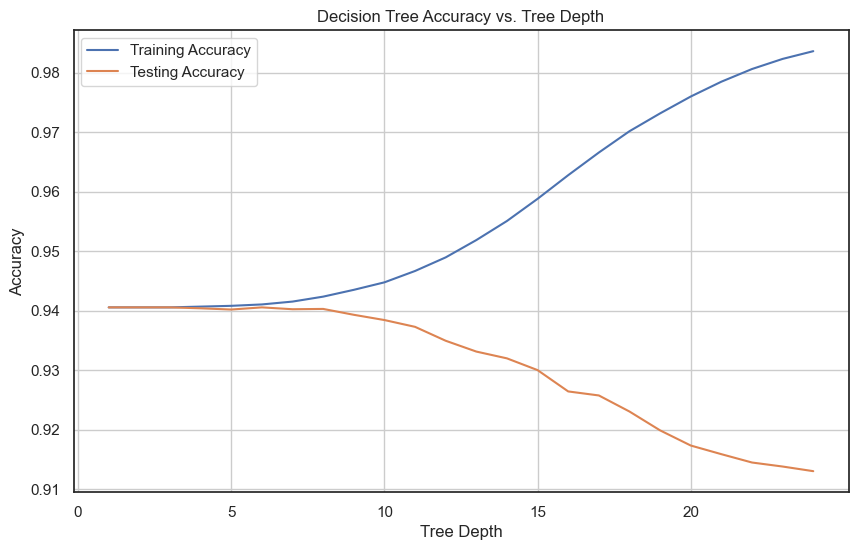

In [ ]:
#plotting the different tree depths
plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), training_accuracies, label='Training Accuracy')
plt.plot(range(1, 25), testing_accuracies, label='Testing Accuracy')
plt.title('Decision Tree Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 25, 5))
plt.show()

Similar to the run without hemoglobin, decision tree models are ideal at a max depth of 5. After this point, the training and testing accuracies begin to diverge.

In [ ]:
dt, training_accuracy, testing_accuracy = build_decision_tree_2(max_depth = 5)
best_feature_idx = np.argmax(dt.feature_importances_)
best_feature = X4.columns[best_feature_idx]
print("The %d-th feature called **%s** is the most importance feature"%(best_feature_idx, best_feature))

Training Accuracy : 0.9408, Testing Accuracy: 0.9402
The 2-th feature called **age** is the most importance feature


The accuracies are still very high with no overfitting, but by now we should know that accuracy does not tell the whole story. We will look at precision and recall right after.

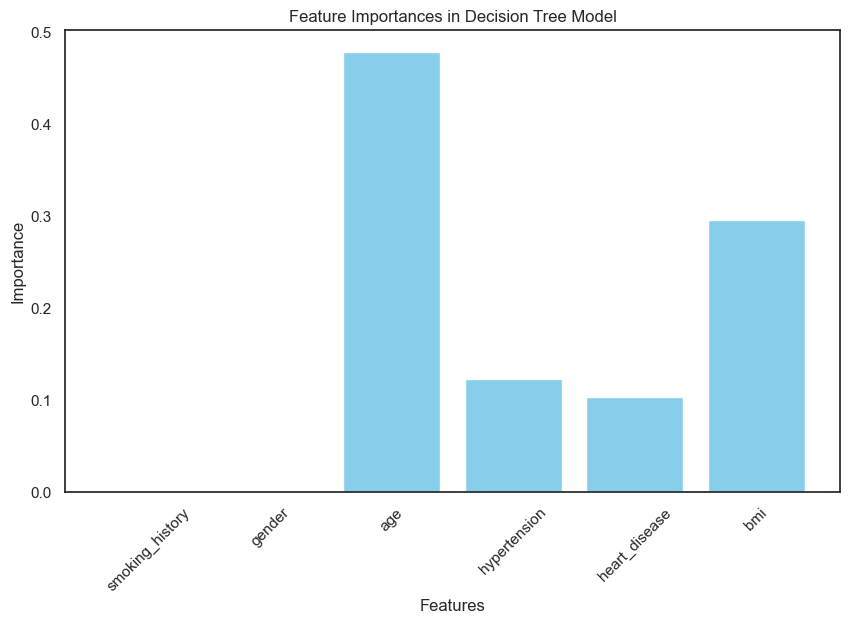

In [ ]:
feature_columns = no_hemo_no_glu_df.columns
feature_importance = dt.feature_importances_
feature_names = feature_columns[0:6]


plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance, color='skyblue')
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


We have determined that age and bmi are important factors in determining diabetes, after there is no hemoglobin or blood glucose levels in the dataset. Decision trees had a pretty accurate model of 91% both training and testing, but recall is really poor. We explore hyperparameter tuning and random forests to improve the model and see if recall can get higher.

### *Part 5.4: Finding Optimal Model with Hyperparameter Training*

In [ ]:
#getting our accuracy, recall, and precision numbers
train_pred_dt = dt.predict(X4_train)
test_pred_dt = dt.predict(X4_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score
dt_accuracy_training = accuracy_score(y4_train, train_pred_dt)
dt_accuracy_test = accuracy_score(y4_test, test_pred_dt)
dt_recall_training = recall_score(y4_train, train_pred_dt)
dt_recall_test = recall_score(y4_test, test_pred_dt)
dt_precision_training =  precision_score(y4_train, train_pred_dt)
dt_precision_test = precision_score(y4_test, test_pred_dt)

training_metrics = [dt_accuracy_training, dt_recall_training, dt_precision_training]
labels = ['accuracy', 'recall', 'precision']
testing_metrics = [dt_accuracy_test, dt_recall_test, dt_precision_test]
#getting our accuracy, recall, and precision numbers

noHbA1c_noglu_dttest = np.mean(testing_metrics)
final_model_performance.append(noHbA1c_noglu_dttest)


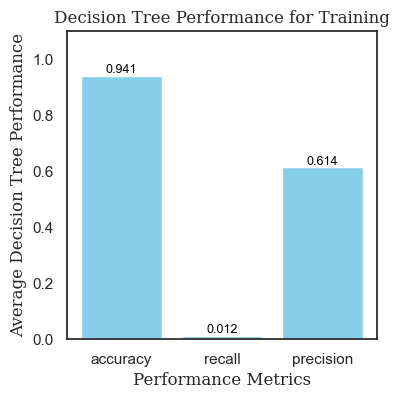

In [ ]:
#plotting our numbers
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Training', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

It looks like recall and precision is insanely low. Just like I predicted, accuracy does not tell the whole story, and there is a lot of work that needs to be done. We will need to really improve our model.

Recall is very important especially for diabetes prediction, as it means there is a very high amount of false negatives. In this case, a lot of people that are predicted to be at high risk for diabetes will not be diagnosed.

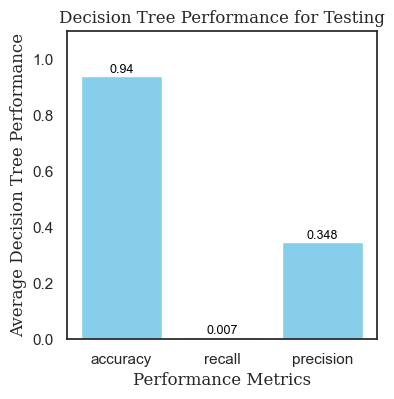

In [ ]:
#plotting our numbers for testing
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, testing_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

The same inaccuracy applies to the test performance. This means that there is only 2% of the total people at risk with diabetes is correctly predicted. This will be our main focus for model improvement.

In [ ]:
seed = 12345
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define the model
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [None, 2, 5, 7, 10],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='recall', verbose=2, n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X4_train, y4_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Similar to our previous hyperparameter tuning we choose to depend on max_depth as it has more flexibility with random forests and vary n_estimators. It seems that we are only able to reach 19% recall accuracy. What this means about our data is that the blood glucose level and the hemoglobin level is very crucial in correctly predicting diabetes, and positive prediction would be inaccurate if we do not have those features.

In [ ]:
rf_best2 = RandomForestClassifier(max_depth=None, n_estimators= 3)
rf_best2.fit(X4_train, y4_train)
#getting our accuracy, recall, and precision numbers
train_pred_rf = rf_best2.predict(X4_train)
test_pred_rf = rf_best2.predict(X4_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score
rf_accuracy_training = accuracy_score(y4_train, train_pred_rf)
rf_accuracy_test = accuracy_score(y4_test, test_pred_rf)
rf_recall_training = recall_score(y4_train, train_pred_rf)
rf_recall_test = recall_score(y4_test, test_pred_rf)
rf_precision_training =  precision_score(y4_train, train_pred_rf)
rf_precision_test = precision_score(y4_test, test_pred_rf)

training_metrics = [rf_accuracy_training, rf_recall_training, rf_precision_training]
labels = ['accuracy', 'recall', 'precision']
testing_metrics = [rf_accuracy_test, rf_recall_test, rf_precision_test]
noHbA1c_noglu_rftest = np.mean(testing_metrics)
final_model_performance.append(noHbA1c_noglu_rftest)

In [ ]:
#plotting our numbers for training
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, training_metrics, color='skyblue')
plt.xlabel('Performance Metrics', family='serif', fontsize = 12)
plt.ylabel('Average Decision Tree Performance', family='serif', fontsize = 12)
plt.title('Decision Tree Performance for Testing', family='serif',  fontsize = 12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

It seems that we have finally reached a point where our model is not complex enough for us to get a decent accuracy. This is where NN comes in.

### *Part 5.5: Neural Network Training*

Since decision trees and random forests does not work well even with hyper-parameter tuning, we will use NN to see if we can achieve better results.

In [ ]:
import torch
print(torch.__version__)

2.3.0


In [ ]:
#import libraries for neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler


We will set up the data for training here.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X4_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y4_train.squeeze(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X4_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y4_test.squeeze(), dtype=torch.long).to(device)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


We defined our model with 2 layers.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X4_train.shape[1], 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

model = NeuralNetwork()


In [ ]:
# Move model to GPU if available

model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model(10)  # Train for 10 epochs


Epoch [1/10], Loss: 0.0843
Epoch [2/10], Loss: 0.3550
Epoch [3/10], Loss: 0.2112
Epoch [4/10], Loss: 0.1817
Epoch [5/10], Loss: 0.2116
Epoch [6/10], Loss: 0.2263
Epoch [7/10], Loss: 0.2307
Epoch [8/10], Loss: 0.3823
Epoch [9/10], Loss: 0.3557
Epoch [10/10], Loss: 0.0507


Training Data - Accuracy: 0.94, Precision: 0.92, Recall: 0.94


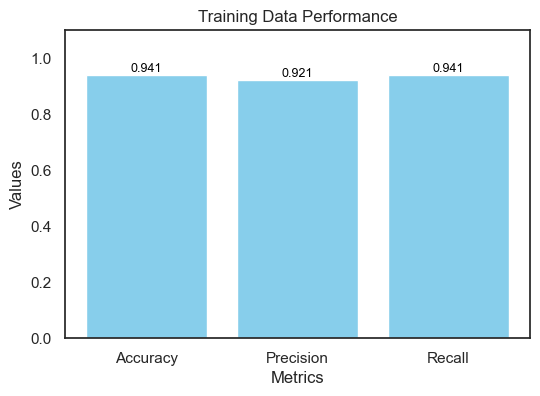

Test Data - Accuracy: 0.94, Precision: 0.91, Recall: 0.94


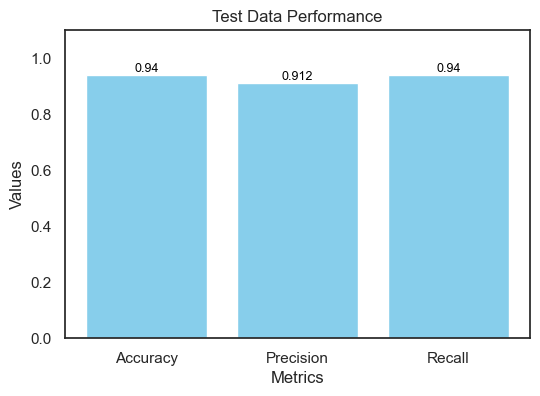

In [ ]:
def evaluate_model_metrics(loader, NNmodel, data_type='Test'):
    NNmodel.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = NNmodel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())  # Collect true labels
            y_pred.extend(predicted.cpu().numpy())  # Collect predictions

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Adjust 'average' as needed
    recall = recall_score(y_true, y_pred, average='weighted')  # Adjust 'average' as needed

    print(f'{data_type} Data - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

    # Plotting the metrics
    metrics = [accuracy, precision, recall]
    labels = ['Accuracy', 'Precision', 'Recall']
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, metrics, color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title(f'{data_type} Data Performance')
    plt.ylim([0, 1.1])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

    plt.show()
    return metrics

# Evaluate on training data
evaluate_model_metrics(train_loader, model, 'Training')

# Evaluate on test data
testing_metrics = evaluate_model_metrics(test_loader, model, 'Test')
noHbA1c_noglu_nntest = np.mean(testing_metrics)
final_model_performance.append(noHbA1c_noglu_nntest)


Looks like the accuracy has been greatly improved with NN! All accuracy metrics are around 90% for both train and test, so there are not much overfitting happen, and it is a lot more accurate than when we did the random forest.

What we can do, is further tune our NN, using a validation dataset.

### *Part 5.6: NN tuning with validation*

We will split our train set into train and validation.

In [ ]:
#splitting data into validation
X_temp, X_test, y_temp, y_test = train_test_split(X4_train, y4_train, test_size=0.20, random_state=42)

# Split training + validation set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)  # Ensure y_train is appropriately squeezed
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.squeeze(), dtype=torch.long)


In [ ]:
# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [ ]:

import copy

def train_and_validate_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = val_correct / val_total
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.4f}')

        # Check if this is the best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'New best model found!')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Example criterion and optimizer setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Call to train and validate the model
best_model = train_and_validate_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=25)


Epoch 1/25, Validation Accuracy: 0.9387
New best model found!
Epoch 2/25, Validation Accuracy: 0.9387
New best model found!
Epoch 3/25, Validation Accuracy: 0.9388
New best model found!
Epoch 4/25, Validation Accuracy: 0.9386
Epoch 5/25, Validation Accuracy: 0.9387
Epoch 6/25, Validation Accuracy: 0.9387
Epoch 7/25, Validation Accuracy: 0.9386
Epoch 8/25, Validation Accuracy: 0.9387
Epoch 9/25, Validation Accuracy: 0.9388
New best model found!
Epoch 10/25, Validation Accuracy: 0.9387
Epoch 11/25, Validation Accuracy: 0.9387
Epoch 12/25, Validation Accuracy: 0.9384
Epoch 13/25, Validation Accuracy: 0.9387
Epoch 14/25, Validation Accuracy: 0.9387
Epoch 15/25, Validation Accuracy: 0.9388
Epoch 16/25, Validation Accuracy: 0.9385
Epoch 17/25, Validation Accuracy: 0.9387
Epoch 18/25, Validation Accuracy: 0.9387
Epoch 19/25, Validation Accuracy: 0.9389
New best model found!
Epoch 20/25, Validation Accuracy: 0.9387
Epoch 21/25, Validation Accuracy: 0.9387
Epoch 22/25, Validation Accuracy: 0.93

Training Data - Accuracy: 0.94, Precision: 0.93, Recall: 0.94


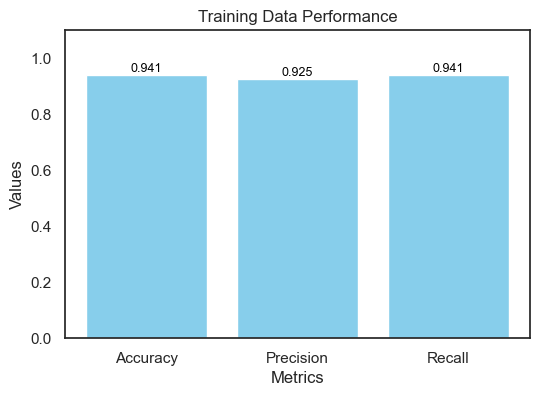

Test Data - Accuracy: 0.94, Precision: 0.91, Recall: 0.94


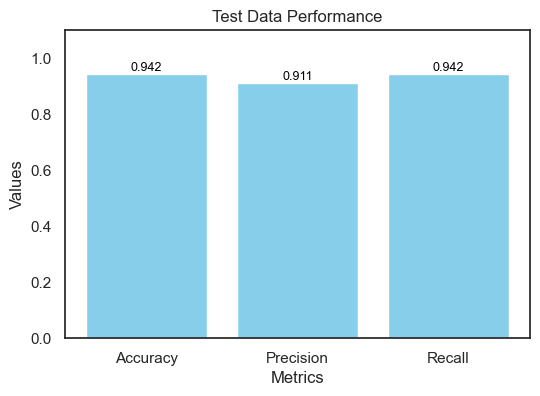

In [ ]:
# Evaluate on training data
evaluate_model_metrics(train_loader, best_model, 'Training')

# Evaluate on test data
testing_metrics = evaluate_model_metrics(test_loader, best_model, 'Test')
noHbA1c_noglu_nntest = np.mean(testing_metrics)
final_model_performance.append(noHbA1c_noglu_nntest)

It looks like even with validation, we are not able to improve the data accuracy any more. Overall, we are very satisfied with this prediction NN model. Even without the crucial predictor of "HBa1c" and "blood glucose level", we are able to achieve great performance in all 3 metrics with the unseen testing dataset. Yet, it is unsettling that we don't know the exact features this model has learned, especially when it comes to a clinical problem. In another sense, if this model were to be used just as a precaution for suggesting a doctor visit, it likely would be really successful.

## ***Part 6: Findings and Conclusion***

Diabetes is a chronic metabolic condition that results in high blood glucose levels leading to other health problems. This disease affects 34.8 million people just in the United States and has been deemed the seventh leading cause of death. Early signs can lead to preventative care, but are often hard to identify in many patients as doctor visits without illness become irregular into adulthood.

In this study, we investigate training of a classifier model to determine if patients will have diabetes given various features in a tabular data form. While the results we aim for is classifying diabetes accurately, precisely and with a good recall score, the overarching purpose of this project was to build a classifier that could potentially be used at home to determine if a person may want a doctor's visit to determine if they have diabetes. We start by explorations in an open dataset with features that are mostly obtained at home except HbA1c (which requires a clinical tests).
We learn in class that designing an optimal machine learning often comes down to balancing a trade off between variance and bias. In the case of classifiers for clinical purposes, recall is also important. Below we show summaries of average performances on testing data with accuracy, precision, and recall, for each model we explored in our entire training dataset and in subsets of our training data.

#### Overall Average Performance of Each Model on All Data

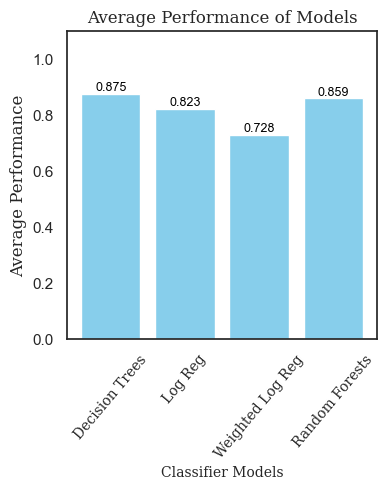

In [ ]:
##plotting final comparisons of models

all_data_labels = ["Decision Trees", "Log Reg", "Weighted Log Reg", "Random Forests"]
all_data_summary = final_model_performance[0:4]
#plotting our numbers
plt.figure(figsize=(4, 4))
bars = plt.bar(all_data_labels, all_data_summary, color='skyblue')
plt.xlabel('Classifier Models', family='serif', fontsize = 10)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Average Performance of Models', family='serif',  fontsize = 12)

plt.xticks(rotation=50, family = 'serif', fontsize = 10)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

#### Overall Average Performance of Decision Trees and Random Forests in Training Data w/o HbA1c Levels

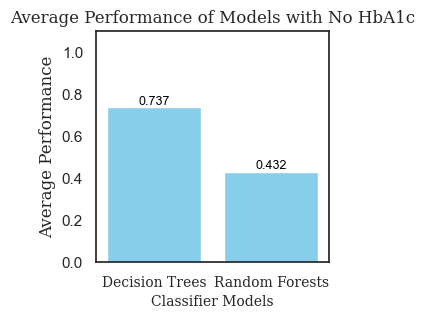

In [ ]:
##plotting final comparisons of models

noHbA1c_data_labels = ["Decision Trees", "Random Forests"]
noHbA1c_data_summary = final_model_performance[4:6]
#plotting our numbers
plt.figure(figsize=(3, 3))
bars = plt.bar(noHbA1c_data_labels, noHbA1c_data_summary, color='skyblue')
plt.xlabel('Classifier Models', family='serif', fontsize = 10)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Average Performance of Models with No HbA1c', family='serif',  fontsize = 12)

plt.xticks(family = 'serif', fontsize = 10)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

#### Overall Average Performance in Each Model for Training Data w/o HbA1c or Blood Glucose Levels

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (3,).

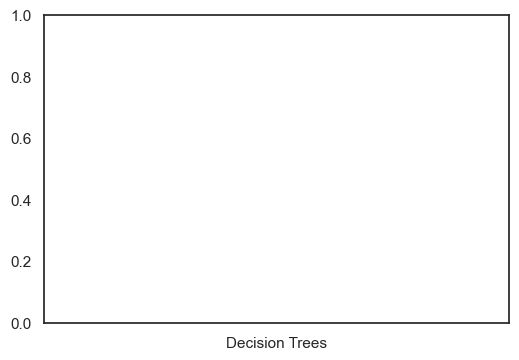

In [ ]:
noHbA1c_data_labels = ["Decision Trees", "Random Forests", "Neural Nets", "Neural Nets w/ Tuning"]
noHbA1c_data_summary = final_model_performance[6:10]
#plotting our numbers
plt.figure(figsize=(6, 4))
bars = plt.bar(noHbA1c_data_labels, noHbA1c_data_summary, color='skyblue')
plt.xlabel('Classifier Models', family='serif', fontsize = 10)
plt.ylabel('Average Performance', family='serif', fontsize = 12)
plt.title('Average Performance of Models with No HbA1c or Blood Glucose Levels', family='serif',  fontsize = 12)

plt.xticks(rotation = 10, family = 'serif', fontsize = 10)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', fontsize=9, color='black')

plt.ylim([0, 1.1])
plt.show()

## **Conclusions**
After cleaning the data, we found that blood glucose level, hemoglobin level, and age are most predictive of diabetes. We found that former smokers, males, people with high hemoglobin levels and blood glucose levels, and people with higher BMI's were overall more likely to have diabetes. We also made interactive data visualizations to demonstrate trends we see in the data, and to examine the relationships between features that are predictive of diabetes.

For the models trained on all features, including HbA1c, we observe remarkable overall performance with the best being attributed to decision tree models. We originally hypothesized that the decision tree model would work best as it most resembles the process a doctor may use to diagnose diabetes. Using feature importances we found that the training was actually skewed to HbA1c levels being the most important.

Because we want to build a classifier that could be used in the home we used the next best two features to explore K-means clustering. In these results, a cluster size of 3 achieved what looked like a logical split of the data, patients with high BMI were in one group, patients with low BMI but high blood glucose levels were another group and lastly patients with low BMI and low blood glucose levels were another group. This suggested training on a dataset without HbA1c would still result in representative features motivating us to make further model explorations in Part 5.

We began with an exploration of classifier training on a dataset without HbA1c. Since decision trees and random forests performed the best before, we proceeded with these two architectures. After hyperparameter tuning, the decision tree and random forest performances on this dataset was actually quite good considering it had no HbA1c. Decision trees model is still slightly better than random forests. Although, recall decreases by almost half of what it was before, meaning we had many more false positives. This isn't entirely bad because a doctor's visit and the HbA1c test could confirm the negativity if someone were to use this model. The false negative rate was still low, fortunately predicting positive for people who are at risk of diabetes. However, from the feature importances in this model we realize training is actually skewed on blood glucose levels. Because not everyone has a device to measure blood glucose levels at home, we proceed with further classifier training methods without HbA1c or blood glucose levels.

Finally, decision trees and random forests after hyperparameter tuning were trained on the dataset without using HbA1c or blood glucose levels as features. Unfortunately, model performance decreased severely especially in the recall score. It was clear using traditional architechtures was not a suited approach for the features in this subset. Given this, we tried a neural network approach using two linear layers, ReLu activation, and Adam optimization. While the first neural network without tuning on validation data was already very good, after tuning average overall performance increased significantly. Yet, an unsettling aspect of this model is that we do not get to see what exact features were learned. Since it is the most accessible form of the model (without the need for a blood glucose measuring device, or past HbA1c levels), the **tuned neural network model** would be the most feasible solution. However, if we truly wanted to understand the training features before deploying a tool like this, the **decision tree model without HbA1c levels** would be most accessible solution.



## **Notes**
Per the rubric section 3, we applied the following topics:
1. Feature importance
2. Feature selection (removing features)
3. Other visualization packages (slider, widgets)
4. Feature engineering (ordinal encoding)
5. Ensemble models



Per the rubric section 8, we used the following 5 course topics:
1. pandas
2. PandaSQL
3. Supervised Learning models
4. Predictive and interpretable models (neural networks)
5. Unsupervised Learning models